In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
model = ExtraTreesRegressor(random_state=1)

# Loading Data

In [3]:
study = pd.read_csv('../brassica.csv')
# Selecting columns with labels and expression elements counts
study = study[['cross', 'reference', 'chr', 'start', 'end','srec', 'gene', 'mRNA', 'exon', 'CDS']]

In [4]:
cauliflower_kohlrabi = study[study['cross'] == 'cauliflower_kohlrabi']

In [5]:
cauliflower_kohlrabi

cross    reference   chr     start       end      srec  \
20676  cauliflower_kohlrabi  cauliflower  chr1         0    100000  0.000000   
20677  cauliflower_kohlrabi  cauliflower  chr1    100000    200000  0.000000   
20678  cauliflower_kohlrabi  cauliflower  chr1    200000    300000  0.000000   
20679  cauliflower_kohlrabi  cauliflower  chr1    300000    400000  0.000000   
20680  cauliflower_kohlrabi  cauliflower  chr1    400000    500000  0.018657   
...                     ...          ...   ...       ...       ...       ...   
31033  cauliflower_kohlrabi     kohlrabi  chr9  64400000  64500000  0.189436   
31034  cauliflower_kohlrabi     kohlrabi  chr9  64500000  64600000  0.170493   
31035  cauliflower_kohlrabi     kohlrabi  chr9  64600000  64700000  0.172100   
31036  cauliflower_kohlrabi     kohlrabi  chr9  64700000  64800000  0.154890   
31037  cauliflower_kohlrabi     kohlrabi  chr9  64800000  64900000  0.139401   

       gene  mRNA  exon  CDS  
20676    15    15    77   77  
20677    19    19    53   53  
20678    31    31   138  138  
20679    14    14    58   58  
20680    20    20    72   72  
...     ...   ...   ...  ...  
31033    13    13    76   76  
31034    16    16    77   77  
31035    22    22   112  112  
31036    11    11    49   49  
31037    16    16    77   77  

[10362 rows x 10 columns]

In [6]:
c = cauliflower_kohlrabi[cauliflower_kohlrabi['reference']=='cauliflower']

In [7]:
ko = cauliflower_kohlrabi[cauliflower_kohlrabi['reference']=='kohlrabi']

# CAULIFLOWER GENOME

# Data exploration

In [8]:
df = c

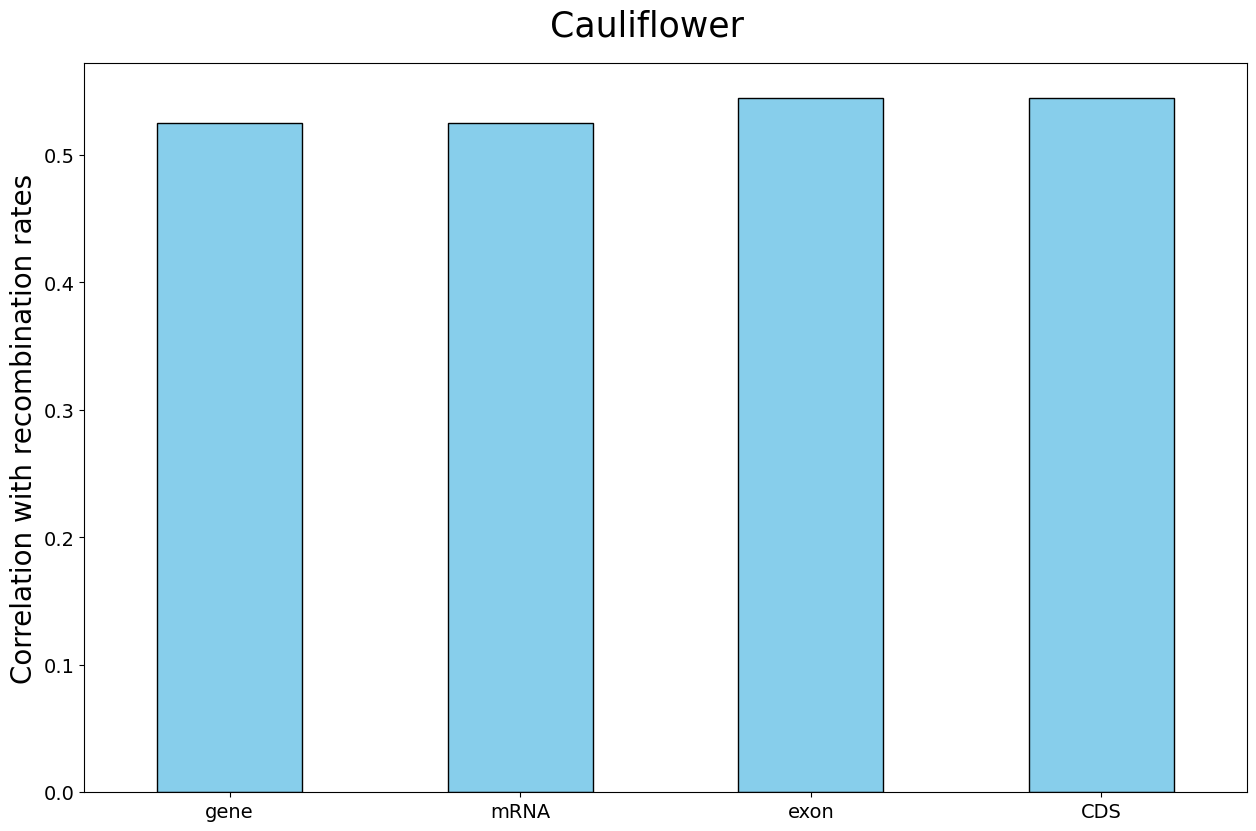

In [9]:
df_stats = df.drop(['cross', 'reference','chr','start','end'],  axis=1)
df_stats_corr = df_stats.corr()['srec'].sort_values(ascending = True)
df_corr = df_stats.corr()
df_corr = df_corr.iloc[1:, :]
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df_corr['srec'].sort_values(ascending = True).plot(kind = 'bar', color='skyblue', edgecolor='black')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Correlation with recombination rates', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.suptitle('Cauliflower', fontsize=25)
plt.subplots_adjust(top=0.92)

plt.show()

# Chromosome Split

In [10]:
chr1 = df[df['chr']== 'chr1']
chr2 = df[df['chr']== 'chr2']
chr3 = df[df['chr']== 'chr3']
chr4 = df[df['chr']== 'chr4']
chr5 = df[df['chr']== 'chr5']
chr6 = df[df['chr']== 'chr6']
chr7 = df[df['chr']== 'chr7']
chr8 = df[df['chr']== 'chr8']
chr9 = df[df['chr']== 'chr9']

In [11]:
achr1 = df[df['chr']!= 'chr1']
achr2 = df[df['chr']!= 'chr2']
achr3 = df[df['chr']!= 'chr3']
achr4 = df[df['chr']!= 'chr4']
achr5 = df[df['chr']!= 'chr5']
achr6 = df[df['chr']!= 'chr6']
achr7 = df[df['chr']!= 'chr7']
achr8 = df[df['chr']!= 'chr8']
achr9 = df[df['chr']!= 'chr9']

# Function to train models and make graphs

The model is trained with the information of all chromosomes except the information of the chromosome to be predicted.

In [12]:
def plot_chromosome_results(chr_number):
    # Replace  with 'chr{chr_number}' 
    chromosomes_data = globals()[f'achr{chr_number}']
    chr_data = globals()[f'chr{chr_number}']

    # TRAINING MODEL
    X_train = chromosomes_data.drop(['cross', 'reference','chr','start','end','srec'], axis=1)
    y_train = chromosomes_data[['srec']]

    model.fit(X_train, y_train)
    model_preds = model.predict(chr_data.drop(['cross', 'reference','chr','start','end','srec'], axis=1))
    
    #SMOOTHING
    model_spreds= np.zeros(len(model_preds))

    for i in  range(1, len(model_preds)): 
        model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9
        
    #CORRELATIONS BY QUARTILES
    c_q1 = int(len(chr_data)*0.25)
    c_q2 = int(len(chr_data)*0.50)
    c_q3 = int(len(chr_data)*0.75)
    
    rq1 = chr_data['srec'].iloc[0:c_q1]
    rq2 = chr_data['srec'].iloc[c_q1:c_q2]
    rq3 = chr_data['srec'].iloc[c_q2:c_q3]
    rq4 = chr_data['srec'].iloc[c_q3:int(len(chr_data))]

    pq1 = model_spreds[0:c_q1]
    pq2 = model_spreds[c_q1:c_q2]
    pq3 = model_spreds[c_q2:c_q3]
    pq4 = model_spreds[c_q3:int(len(chr_data))]

    corr_q1 = np.corrcoef(rq1, pq1)[0, 1]
    corr_q2 = np.corrcoef(rq2, pq2)[0, 1]
    corr_q3 = np.corrcoef(rq3, pq3)[0, 1]
    corr_q4 = np.corrcoef(rq4, pq4)[0, 1]
    
    globals()[f'corr_q1_chr{chr_number}'] = corr_q1
    globals()[f'corr_q2_chr{chr_number}'] = corr_q2
    globals()[f'corr_q3_chr{chr_number}'] = corr_q3
    globals()[f'corr_q4_chr{chr_number}'] = corr_q4
     
    # PLOTTING RESULTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw={'width_ratios': [10, 3]})

    # Line plot and correlation plot
    ax1.plot(chr_data.end, chr_data.srec, label='Recombination')
    ax1.plot(chr_data.end, model_spreds, label='Prediction', color='green')
    ax1.set_title(f'Cauliflower Chromosome {chr_number}', fontsize=20)
    ax1.set_xlabel('chromosomes position (Mb)', fontsize=15)
    ax1.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
    ax1.legend(loc='upper right', fontsize=12)
    ticks = ax1.get_xticks() / 1000000
    ax1.set_xticklabels(ticks)
        
    chr_len = chr_data["end"].iloc[-1]
    q1 =round(chr_len * 0.25 / 100000) * 100000
    q2 =round(chr_len* 0.50 / 100000) * 100000
    q3 =round(chr_len * 0.75 / 100000) * 100000

    ax1.axvline(x=q1, color='gray', linestyle='-')
    ax1.axvline(x=q2, color='gray', linestyle='--')
    ax1.axvline(x=q3, color='gray', linestyle='-')

    # Scatter plot
    scatter = ax2.scatter(chr_data.srec, model_spreds, c='skyblue', edgecolors='black', linewidth= 0.3)
    ax2.set_title('Recombination vs. Prediction', fontsize=15)
    ax2.set_xlabel('Recombination', fontsize=15)
    ax2.set_ylabel('Prediction', fontsize=15)

    # Calculate correlation coefficient, coefficient of determination, and Mean Squared Error
    corr_chr = np.corrcoef(chr_data.srec, model_spreds)[0, 1]
    r2_chr = r2_score(chr_data.srec, model_spreds)
    mse_chr = mean_squared_error(chr_data.srec, model_spreds)

    # Calculate the aspect ratio based on the plot heights
    h1 = ax1.get_ylim()
    h2 = ax2.get_ylim()
    aspect_ratio = max(h1[1] - h1[0], h2[1] - h2[0]) / (max(h1[1], h2[1]) - min(h1[0], h2[0]))

    # Set the aspect ratio for the scatter plot only if it doesn't distort the square shape
    if aspect_ratio < 1:
        ax2.set_aspect('equal')

    # Display correlation coefficient, coefficient of determination, and Mean Squared Error as plain text
    globals()[f'corr_chr{chr_number}'] = corr_chr
    globals()[f'r2_chr{chr_number}'] = r2_chr
    globals()[f'mse_chr{chr_number}'] = mse_chr

    textstr = f'Correlation: {corr_chr:.3f}\nR-squared: {r2_chr:.3f}\nMSE: {mse_chr:.3f}'
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

    # Adjustments to align the heights of the two plots
    max_height = max(h1[1], h2[1])
    ax1.set_ylim([h1[0], max_height])
    ax2.set_ylim([h2[0], max_height])

    # Reduce the separation between the plots
    plt.subplots_adjust(wspace=0.1)
    plt.show()

# Model Predictions

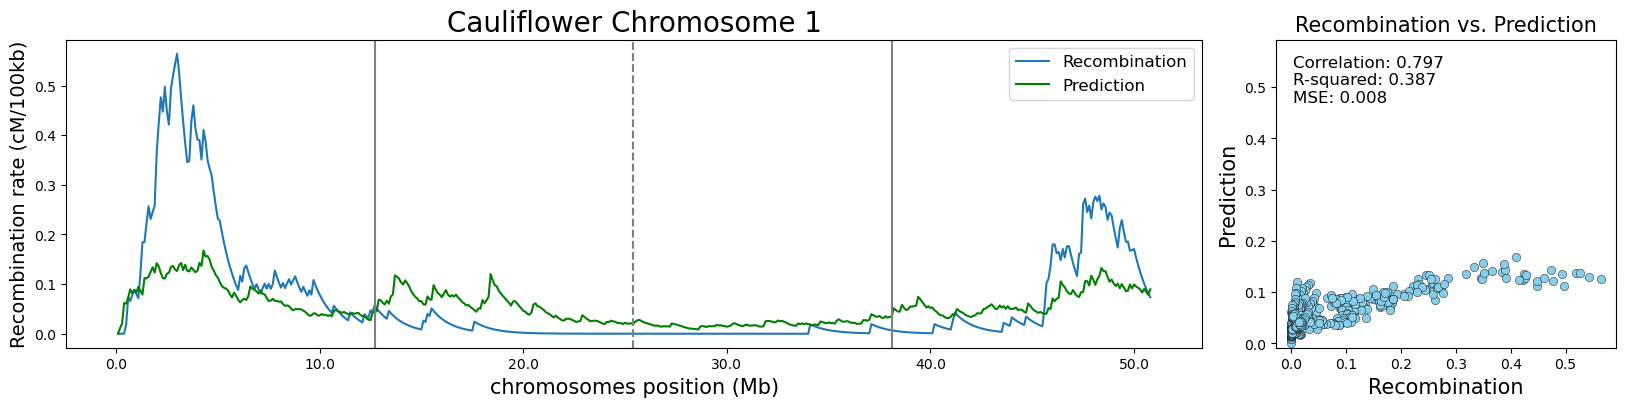

In [13]:
# Predictions for one chromosome, example: Chromosome 1
plot_chromosome_results(1)

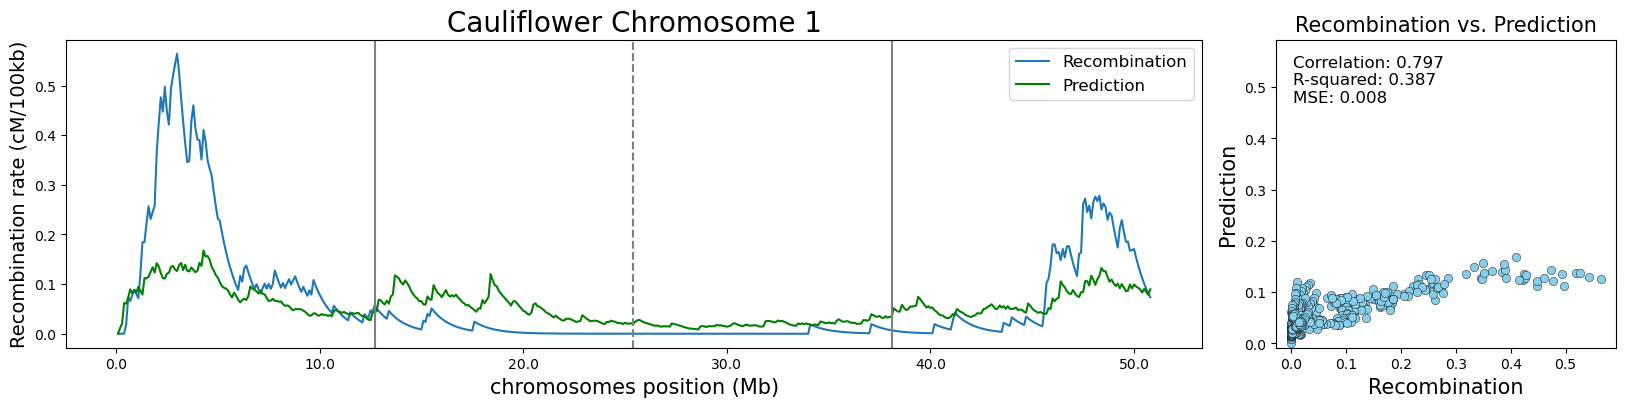

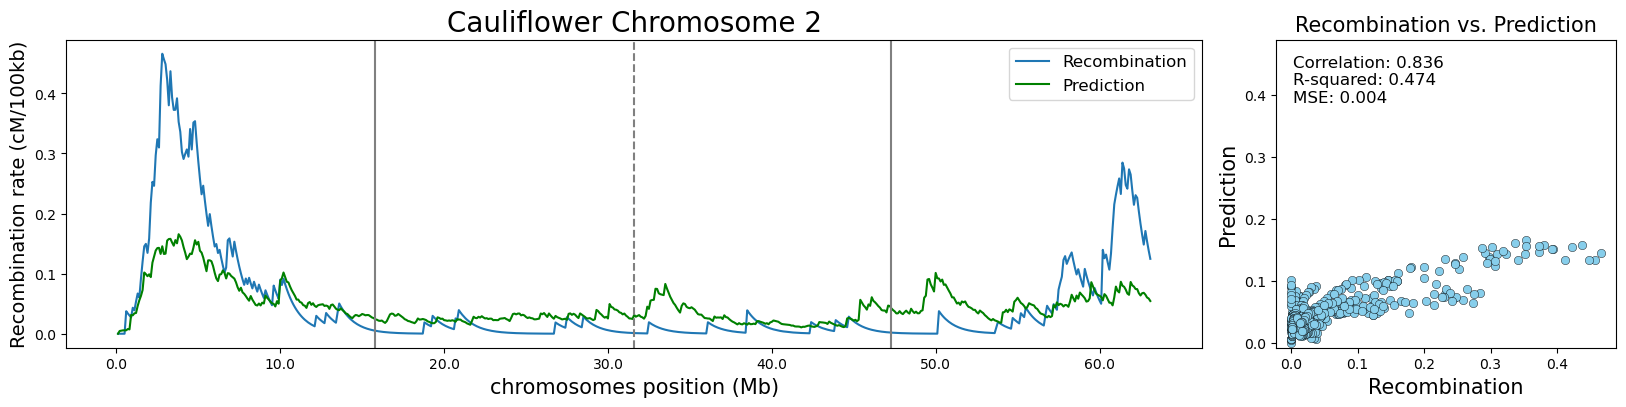

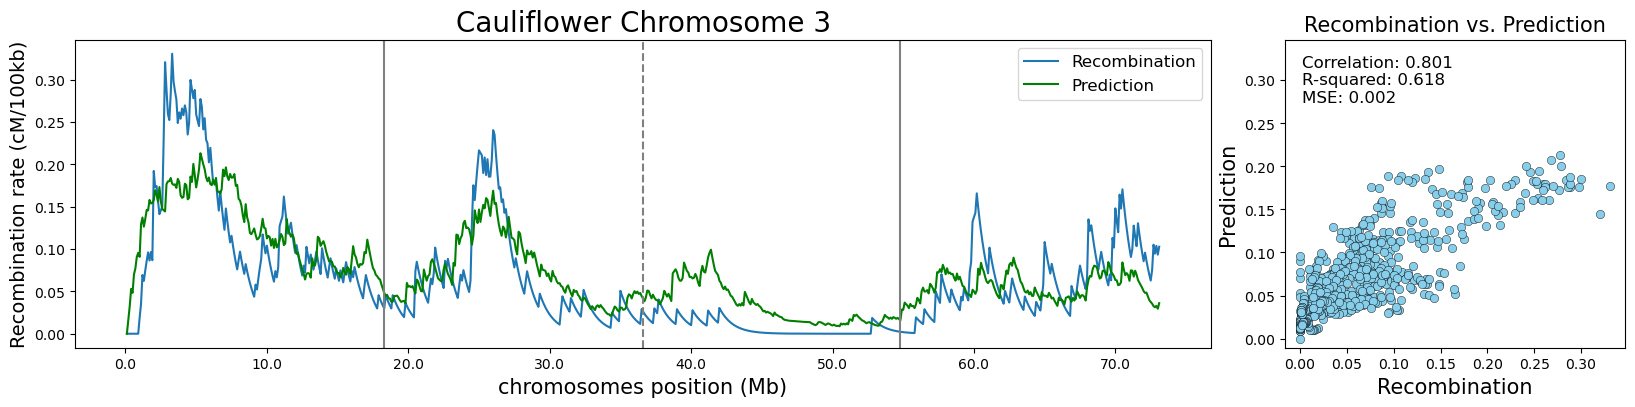

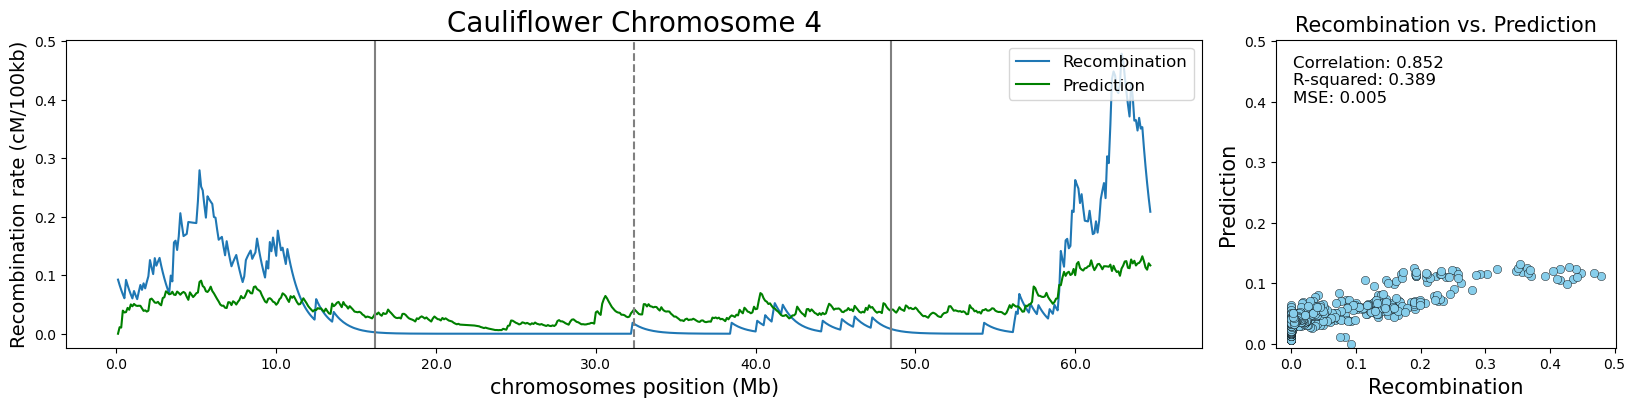

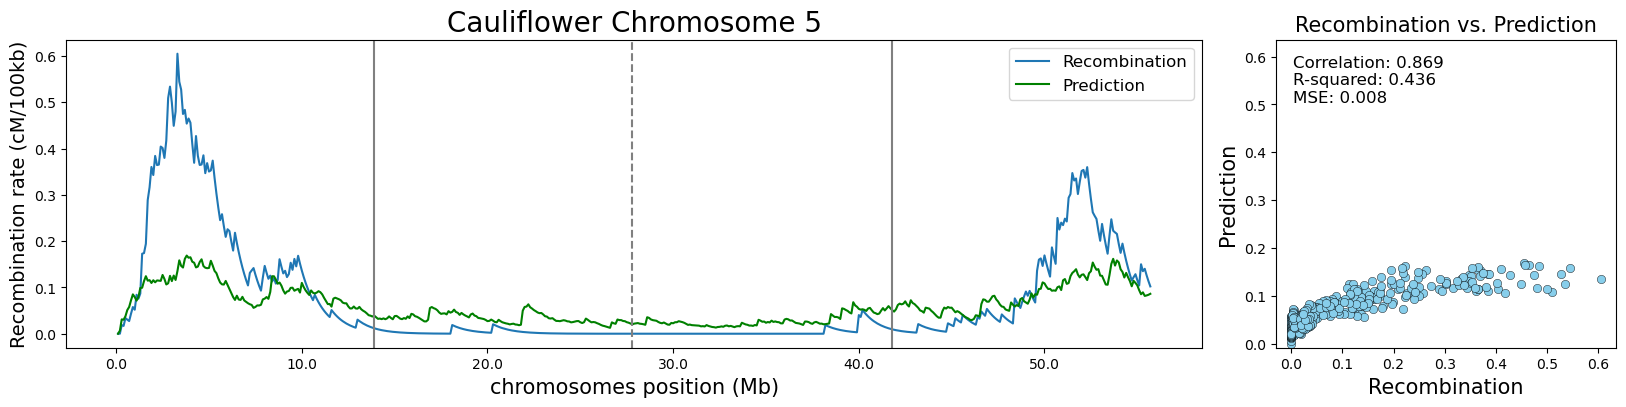

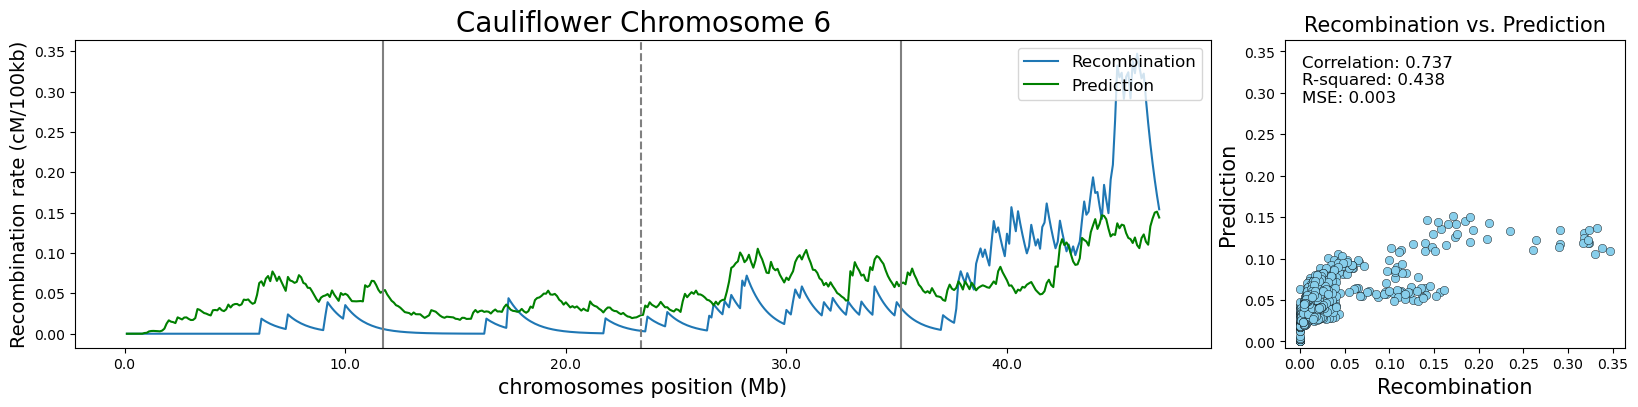

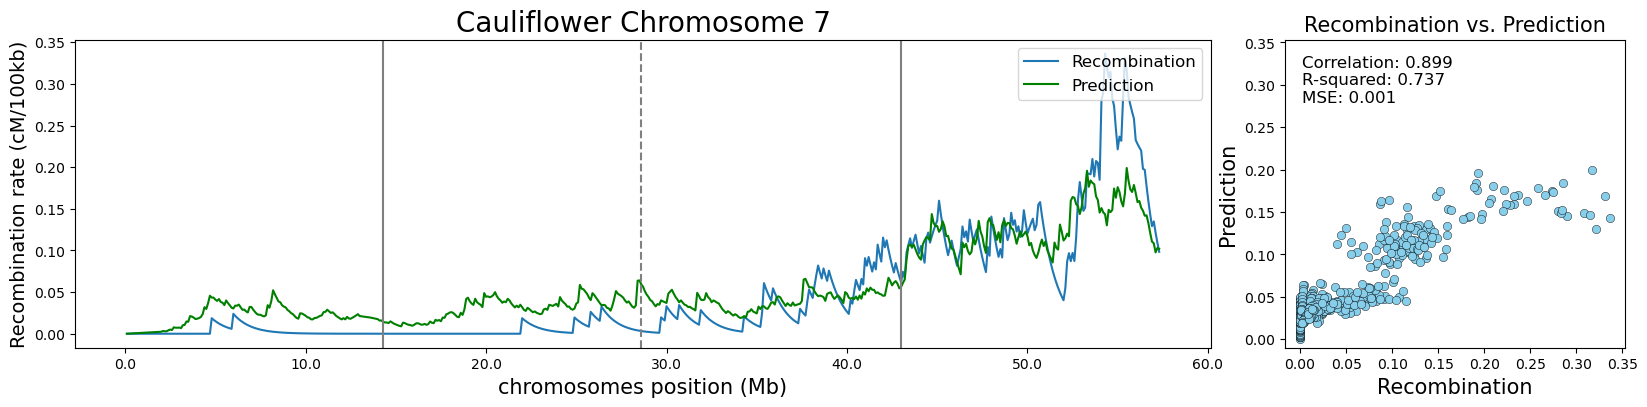

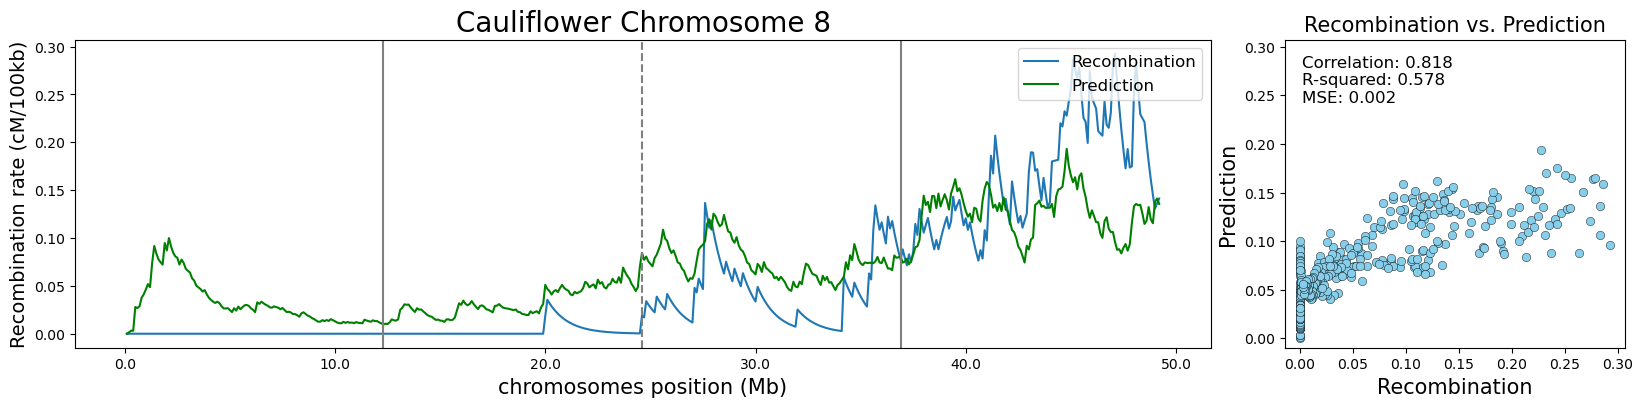

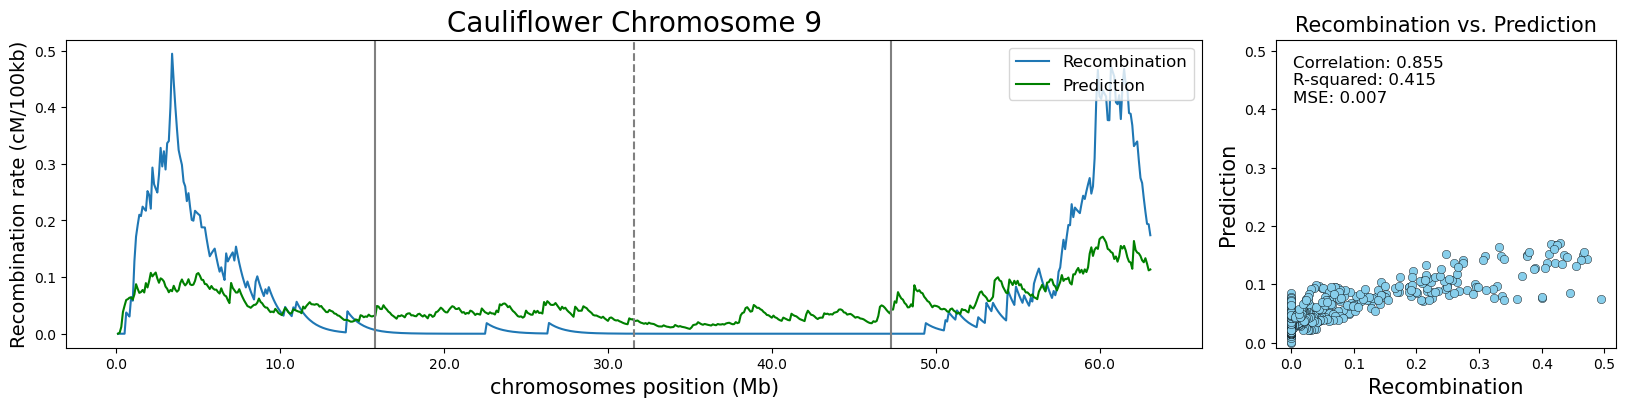

In [14]:
# Predictions and graphs for all chromosomes
for chr_number in range(1, 10):
    plot_chromosome_results(chr_number)
    plt.show()

# Data compilation

In [15]:
corr = pd.DataFrame({'corr':[corr_chr1, corr_chr2, corr_chr3, corr_chr4, corr_chr5, corr_chr6,corr_chr7,corr_chr8,corr_chr9,]})
r2 = pd.DataFrame({'R^2':[r2_chr1, r2_chr2, r2_chr3, r2_chr4, r2_chr5, r2_chr6, r2_chr7, r2_chr8, r2_chr9]})
mse = pd.DataFrame({'MSE':[mse_chr1, mse_chr2, mse_chr3, mse_chr4, mse_chr5, mse_chr6, mse_chr7, mse_chr8, mse_chr9]})
index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9',]})
c_table = pd.concat([index, corr, r2, mse], axis=1)
c_table

chr      corr       R^2       MSE
0  chr1  0.797041  0.386705  0.007585
1  chr2  0.836354  0.474481  0.003989
2  chr3  0.801312  0.617583  0.001641
3  chr4  0.851587  0.388730  0.005357
4  chr5  0.869421  0.435739  0.008282
5  chr6  0.736836  0.438191  0.002658
6  chr7  0.898991  0.736629  0.001258
7  chr8  0.817627  0.578163  0.002379
8  chr9  0.854817  0.415238  0.007128

Correlation between model predictions and recombination rates by quartiles

In [16]:
corr_q1 = pd.DataFrame({'Q1':[corr_q1_chr1,corr_q1_chr2,corr_q1_chr3,corr_q1_chr4,corr_q1_chr5,corr_q1_chr6,corr_q1_chr7,corr_q1_chr8,corr_q1_chr9]})
corr_q2 = pd.DataFrame({'Q2':[corr_q2_chr1,corr_q2_chr2,corr_q2_chr3,corr_q2_chr4,corr_q2_chr5,corr_q2_chr6,corr_q2_chr7,corr_q2_chr8,corr_q2_chr9]})
corr_q3 = pd.DataFrame({'Q3':[corr_q3_chr1,corr_q3_chr2,corr_q3_chr3,corr_q3_chr4,corr_q3_chr5,corr_q3_chr6,corr_q3_chr7,corr_q3_chr8,corr_q3_chr9]})
corr_q4 = pd.DataFrame({'Q4':[corr_q4_chr1,corr_q4_chr2,corr_q4_chr3,corr_q4_chr4,corr_q4_chr5,corr_q4_chr6,corr_q4_chr7,corr_q4_chr8,corr_q4_chr9]})

index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9']})
q_corr = pd.concat([index, corr_q1, corr_q2, corr_q3, corr_q4], axis=1)
q_corr_styled = q_corr.style.background_gradient(cmap="PRGn", vmin=-1, vmax=1)
q_corr_styled.set_table_styles([{'selector': 'th',
                                'props': [('text-align', 'center')]}])
q_corr_styled 

# KOHLRABI GENOME

# Data exploration

In [17]:
df = ko

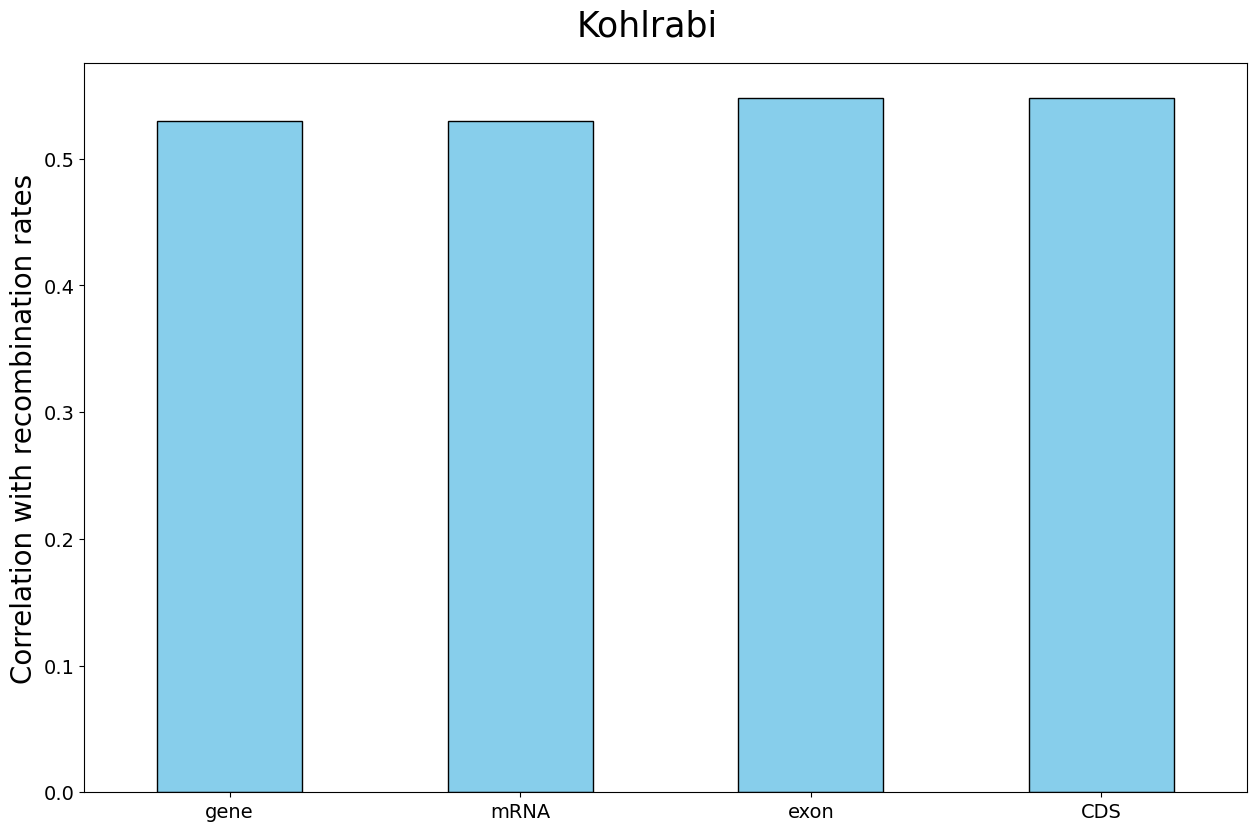

In [18]:
df_stats = df.drop(['cross', 'reference','chr','start','end'],  axis=1)
df_stats_corr = df_stats.corr()['srec'].sort_values(ascending = True)
df_corr = df_stats.corr()
df_corr = df_corr.iloc[1:, :]
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df_corr['srec'].sort_values(ascending = True).plot(kind = 'bar', color='skyblue', edgecolor='black')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Correlation with recombination rates', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.suptitle('Kohlrabi', fontsize=25)
plt.subplots_adjust(top=0.92)

plt.show()

# Chromosome Split

In [19]:
chr1 = df[df['chr']== 'chr1']
chr2 = df[df['chr']== 'chr2']
chr3 = df[df['chr']== 'chr3']
chr4 = df[df['chr']== 'chr4']
chr5 = df[df['chr']== 'chr5']
chr6 = df[df['chr']== 'chr6']
chr7 = df[df['chr']== 'chr7']
chr8 = df[df['chr']== 'chr8']
chr9 = df[df['chr']== 'chr9']

In [20]:
achr1 = df[df['chr']!= 'chr1']
achr2 = df[df['chr']!= 'chr2']
achr3 = df[df['chr']!= 'chr3']
achr4 = df[df['chr']!= 'chr4']
achr5 = df[df['chr']!= 'chr5']
achr6 = df[df['chr']!= 'chr6']
achr7 = df[df['chr']!= 'chr7']
achr8 = df[df['chr']!= 'chr8']
achr9 = df[df['chr']!= 'chr9']

# Function to train models and make graphs

The model is trained with the information of all chromosomes except the information of the chromosome to be predicted.

In [21]:
def plot_chromosome_results(chr_number):
    # Replace  with 'chr{chr_number}' 
    chromosomes_data = globals()[f'achr{chr_number}']
    chr_data = globals()[f'chr{chr_number}']

    # TRAINING MODEL
    X_train = chromosomes_data.drop(['cross', 'reference','chr','start','end','srec'], axis=1)
    y_train = chromosomes_data[['srec']]
    
    model.fit(X_train, y_train)
    model_preds = model.predict(chr_data.drop(['cross', 'reference','chr','start','end','srec'], axis=1))
    
    #SMOOTHING
    model_spreds= np.zeros(len(model_preds))

    for i in  range(1, len(model_preds)): 
        model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9
        
    #CORRELATIONS BY QUARTILES
    c_q1 = int(len(chr_data)*0.25)
    c_q2 = int(len(chr_data)*0.50)
    c_q3 = int(len(chr_data)*0.75)
    
    rq1 = chr_data['srec'].iloc[0:c_q1]
    rq2 = chr_data['srec'].iloc[c_q1:c_q2]
    rq3 = chr_data['srec'].iloc[c_q2:c_q3]
    rq4 = chr_data['srec'].iloc[c_q3:int(len(chr_data))]

    pq1 = model_spreds[0:c_q1]
    pq2 = model_spreds[c_q1:c_q2]
    pq3 = model_spreds[c_q2:c_q3]
    pq4 = model_spreds[c_q3:int(len(chr_data))]

    corr_q1 = np.corrcoef(rq1, pq1)[0, 1]
    corr_q2 = np.corrcoef(rq2, pq2)[0, 1]
    corr_q3 = np.corrcoef(rq3, pq3)[0, 1]
    corr_q4 = np.corrcoef(rq4, pq4)[0, 1]
    
    globals()[f'corr_q1_chr{chr_number}'] = corr_q1
    globals()[f'corr_q2_chr{chr_number}'] = corr_q2
    globals()[f'corr_q3_chr{chr_number}'] = corr_q3
    globals()[f'corr_q4_chr{chr_number}'] = corr_q4
     
    # PLOTTING RESULTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw={'width_ratios': [10, 3]})

    # Line plot and correlation plot
    ax1.plot(chr_data.end, chr_data.srec, label='Recombination')
    ax1.plot(chr_data.end, model_spreds, label='Prediction', color='green')
    ax1.set_title(f'Kohlrabi Chromosome {chr_number}', fontsize=20)
    ax1.set_xlabel('chromosomes position (Mb)', fontsize=15)
    ax1.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
    ax1.legend(loc='upper right', fontsize=12)
    ticks = ax1.get_xticks() / 1000000
    ax1.set_xticklabels(ticks)
        
    chr_len = chr_data["end"].iloc[-1]
    q1 =round(chr_len * 0.25 / 100000) * 100000
    q2 =round(chr_len* 0.50 / 100000) * 100000
    q3 =round(chr_len * 0.75 / 100000) * 100000

    ax1.axvline(x=q1, color='gray', linestyle='-')
    ax1.axvline(x=q2, color='gray', linestyle='--')
    ax1.axvline(x=q3, color='gray', linestyle='-')

    # Scatter plot
    scatter = ax2.scatter(chr_data.srec, model_spreds, c='skyblue', edgecolors='black', linewidth= 0.3)
    ax2.set_title('Recombination vs. Prediction', fontsize=15)
    ax2.set_xlabel('Recombination', fontsize=15)
    ax2.set_ylabel('Prediction', fontsize=15)

    # Calculate correlation coefficient, coefficient of determination, and Mean Squared Error
    corr_chr = np.corrcoef(chr_data.srec, model_spreds)[0, 1]
    r2_chr = r2_score(chr_data.srec, model_spreds)
    mse_chr = mean_squared_error(chr_data.srec, model_spreds)

    # Calculate the aspect ratio based on the plot heights
    h1 = ax1.get_ylim()
    h2 = ax2.get_ylim()
    aspect_ratio = max(h1[1] - h1[0], h2[1] - h2[0]) / (max(h1[1], h2[1]) - min(h1[0], h2[0]))

    # Set the aspect ratio for the scatter plot only if it doesn't distort the square shape
    if aspect_ratio < 1:
        ax2.set_aspect('equal')

    # Display correlation coefficient, coefficient of determination, and Mean Squared Error as plain text
    globals()[f'corr_chr{chr_number}'] = corr_chr
    globals()[f'r2_chr{chr_number}'] = r2_chr
    globals()[f'mse_chr{chr_number}'] = mse_chr

    textstr = f'Correlation: {corr_chr:.3f}\nR-squared: {r2_chr:.3f}\nMSE: {mse_chr:.3f}'
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

    # Adjustments to align the heights of the two plots
    max_height = max(h1[1], h2[1])
    ax1.set_ylim([h1[0], max_height])
    ax2.set_ylim([h2[0], max_height])

    # Reduce the separation between the plots
    plt.subplots_adjust(wspace=0.1)
    plt.show()

# Model Predictions

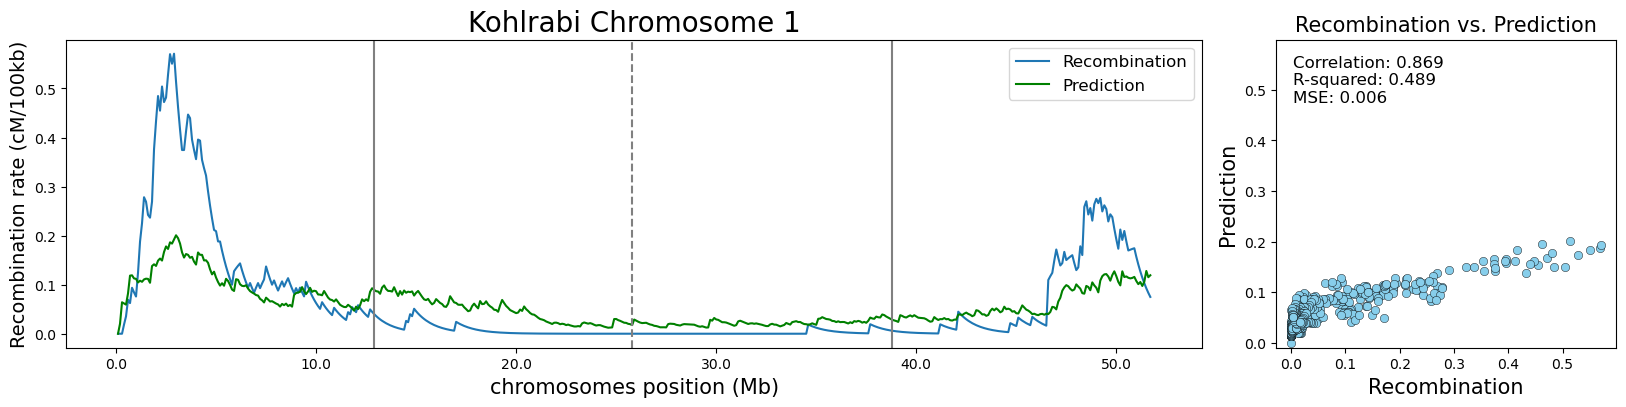

In [22]:
# For one chromosome, example Chromosome 1
plot_chromosome_results(1)

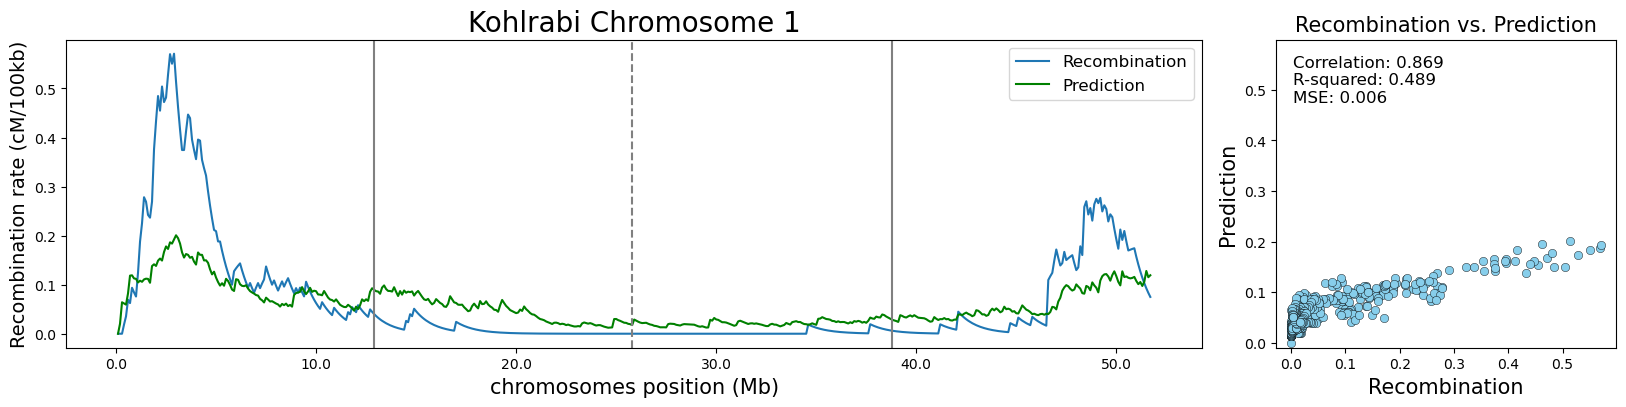

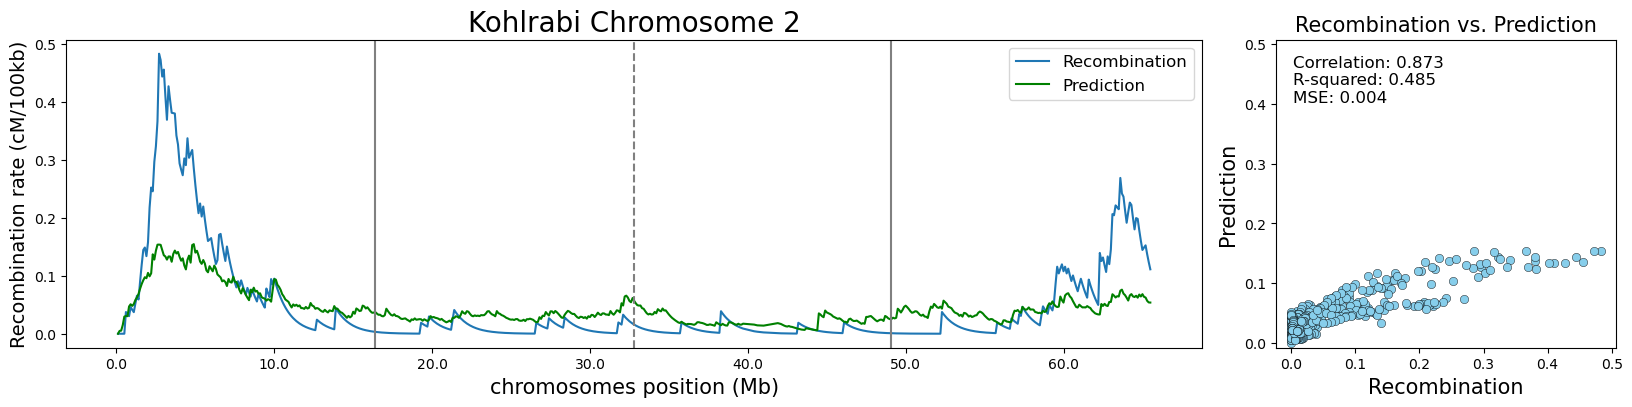

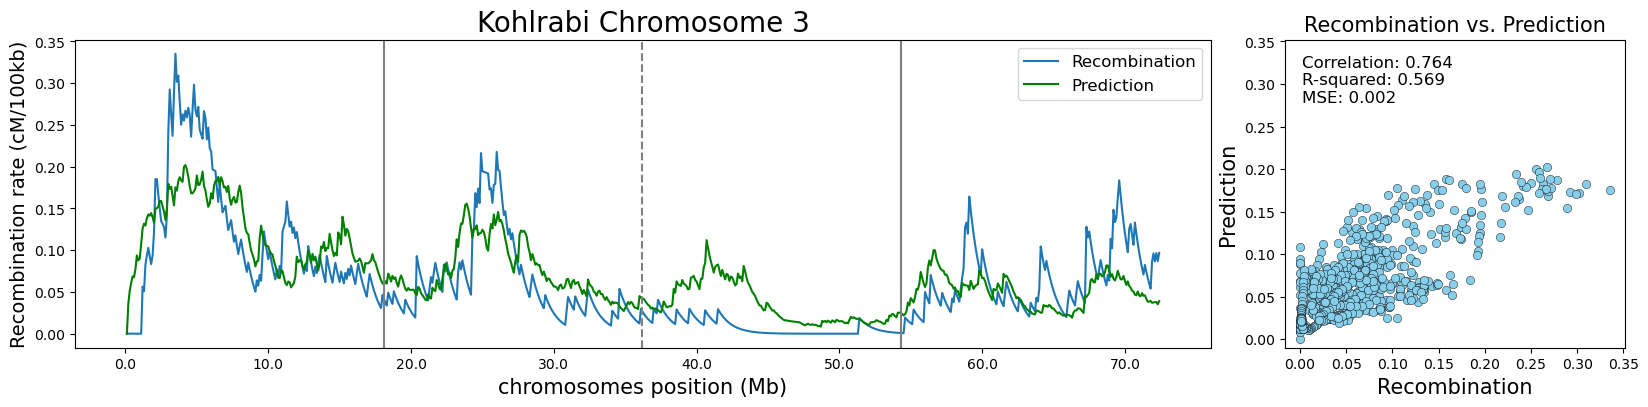

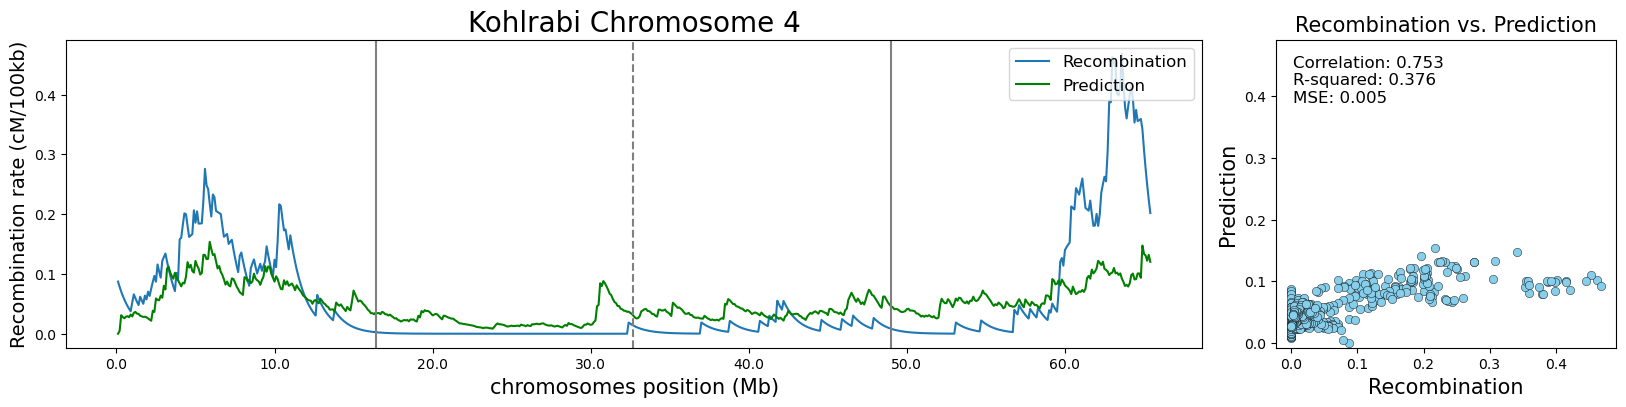

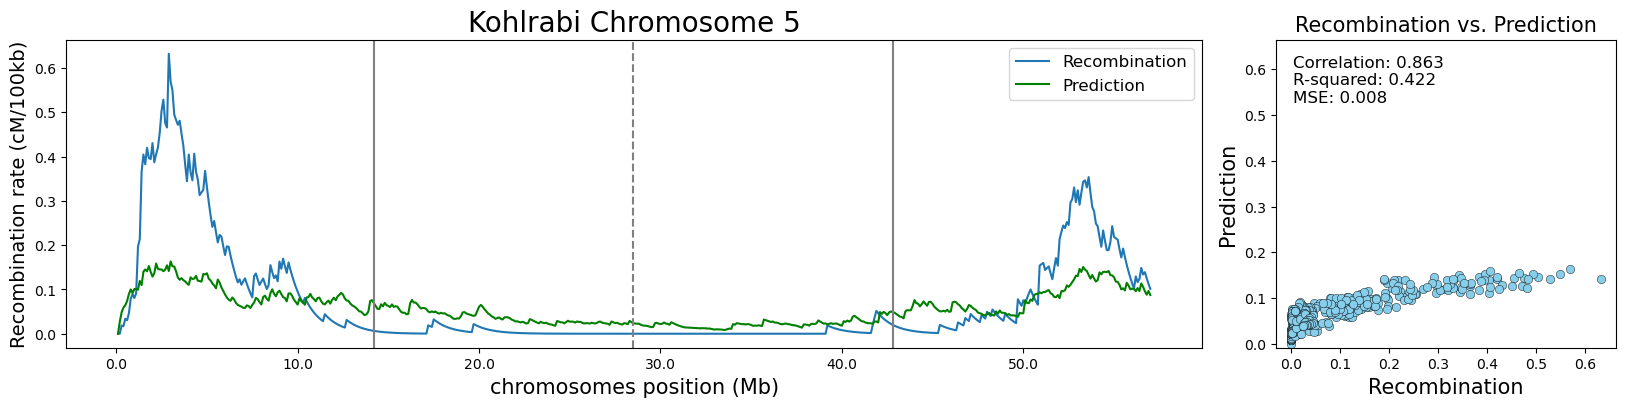

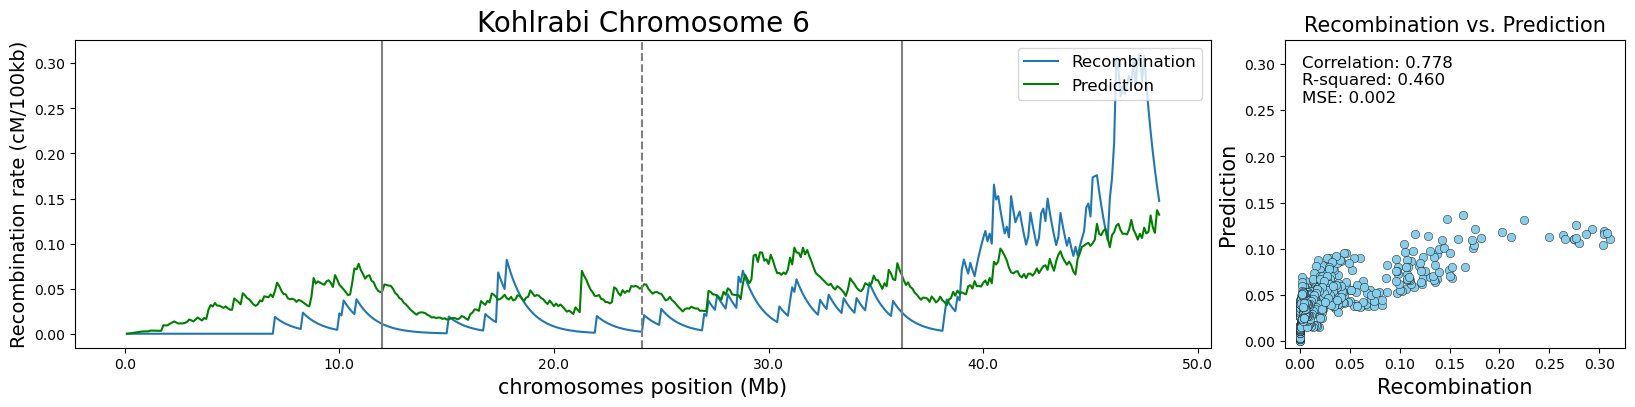

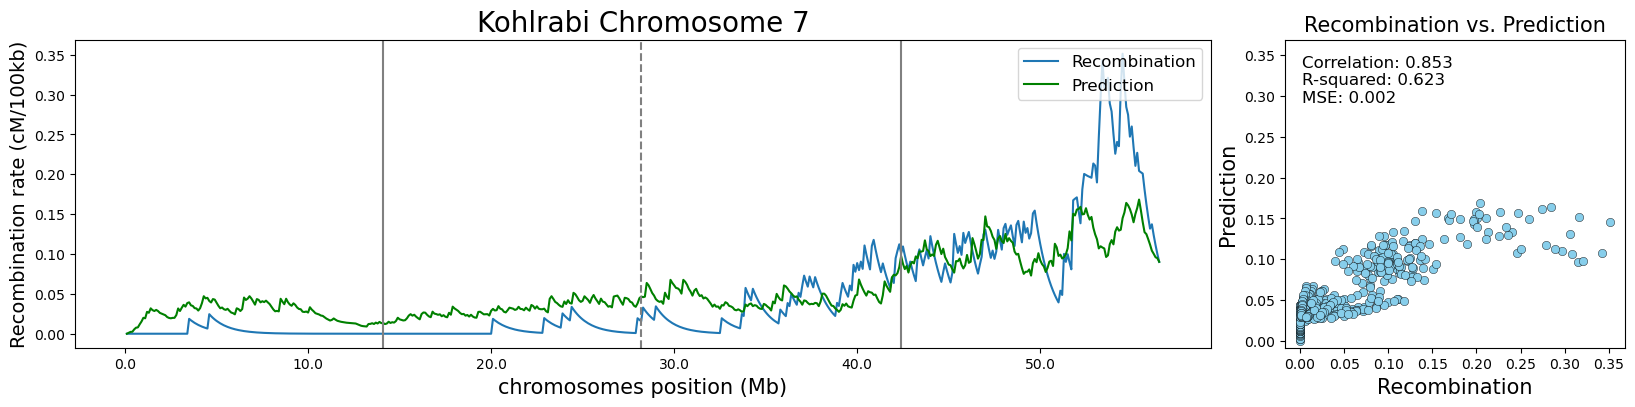

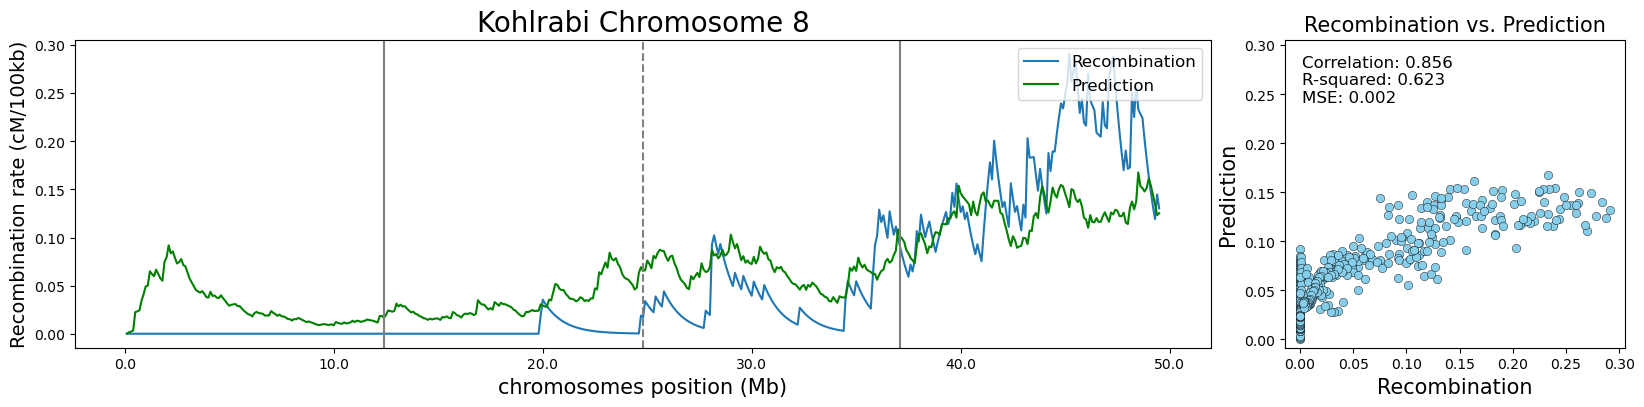

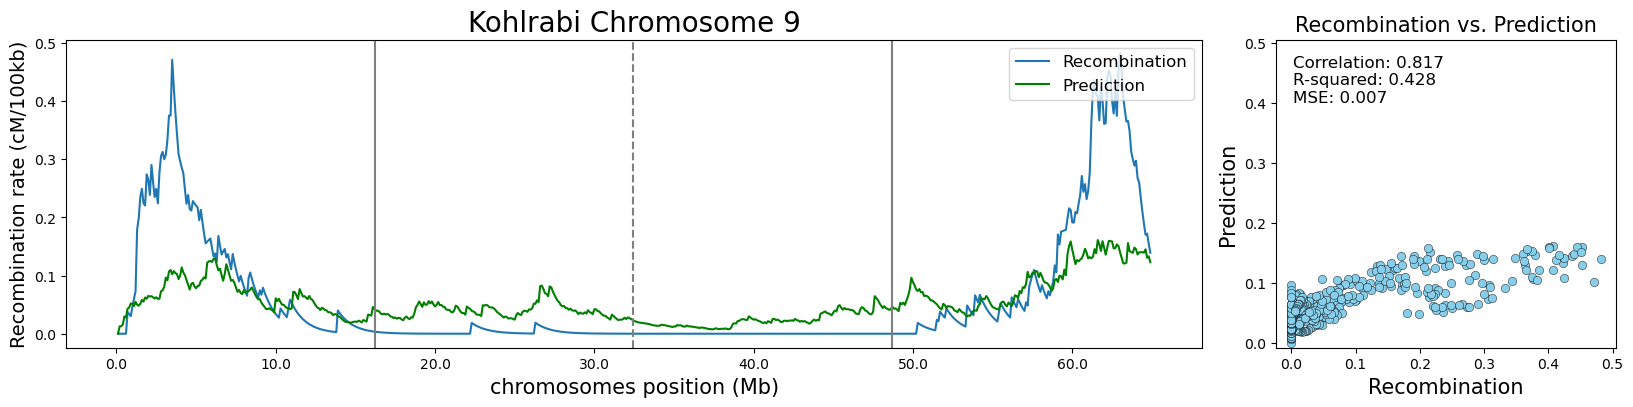

In [23]:
# Predictions and graphs for all chromosomes
for chr_number in range(1, 10):
    plot_chromosome_results(chr_number)
    plt.show()

# Data compilation

In [24]:
corr = pd.DataFrame({'corr':[corr_chr1, corr_chr2, corr_chr3, corr_chr4, corr_chr5, corr_chr6,corr_chr7,corr_chr8,corr_chr9,]})
r2 = pd.DataFrame({'R^2':[r2_chr1, r2_chr2, r2_chr3, r2_chr4, r2_chr5, r2_chr6, r2_chr7, r2_chr8, r2_chr9]})
mse = pd.DataFrame({'MSE':[mse_chr1, mse_chr2, mse_chr3, mse_chr4, mse_chr5, mse_chr6, mse_chr7, mse_chr8, mse_chr9]})
index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9',]})
ko_table = pd.concat([index, corr, r2, mse], axis=1)
ko_table

chr      corr       R^2       MSE
0  chr1  0.869345  0.489460  0.006412
1  chr2  0.872850  0.485018  0.003675
2  chr3  0.763869  0.569408  0.001720
3  chr4  0.753195  0.376210  0.005373
4  chr5  0.863434  0.422083  0.008478
5  chr6  0.778464  0.459811  0.002148
6  chr7  0.852550  0.622507  0.001752
7  chr8  0.856405  0.622917  0.002149
8  chr9  0.817365  0.428236  0.006729

Correlation between model predictions and recombination rates by quartiles

In [25]:
corr_q1 = pd.DataFrame({'Q1':[corr_q1_chr1,corr_q1_chr2,corr_q1_chr3,corr_q1_chr4,corr_q1_chr5,corr_q1_chr6,corr_q1_chr7,corr_q1_chr8,corr_q1_chr9]})
corr_q2 = pd.DataFrame({'Q2':[corr_q2_chr1,corr_q2_chr2,corr_q2_chr3,corr_q2_chr4,corr_q2_chr5,corr_q2_chr6,corr_q2_chr7,corr_q2_chr8,corr_q2_chr9]})
corr_q3 = pd.DataFrame({'Q3':[corr_q3_chr1,corr_q3_chr2,corr_q3_chr3,corr_q3_chr4,corr_q3_chr5,corr_q3_chr6,corr_q3_chr7,corr_q3_chr8,corr_q3_chr9]})
corr_q4 = pd.DataFrame({'Q4':[corr_q4_chr1,corr_q4_chr2,corr_q4_chr3,corr_q4_chr4,corr_q4_chr5,corr_q4_chr6,corr_q4_chr7,corr_q4_chr8,corr_q4_chr9]})

index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9']})
q_corr = pd.concat([index, corr_q1, corr_q2, corr_q3, corr_q4], axis=1)
q_corr_styled = q_corr.style.background_gradient(cmap="PRGn", vmin=-1, vmax=1)
q_corr_styled.set_table_styles([{'selector': 'th',
                                'props': [('text-align', 'center')]}])
q_corr_styled 

# Prediction performance of models trained with Broccoli data and Kohlrabi data.

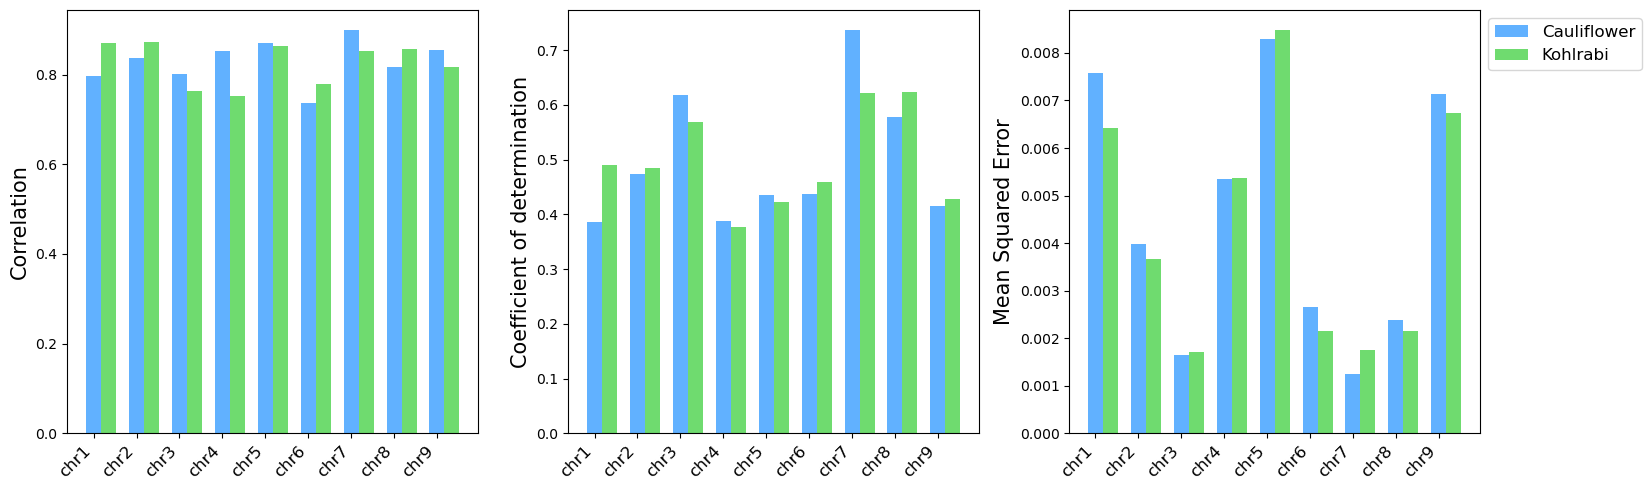

In [26]:
# Adjusting bar width
bar_width = 0.35

# Creating data positions
bar_positions_c = np.arange(len(c_table['chr']))
bar_positions_ko = bar_positions_c + bar_width

# Creating subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First chart
axs[0].bar(bar_positions_c, c_table['corr'], color='dodgerblue', width=bar_width, label='Cauliflower', alpha=0.7)
axs[0].bar(bar_positions_ko, ko_table['corr'], color='limegreen', width=bar_width, label='Kohlrabi', alpha=0.7)

axs[0].set_ylabel('Correlation', fontsize=15)

# Second chart
axs[1].bar(bar_positions_c, c_table['R^2'], color='dodgerblue', width=bar_width, label='Cauliflower', alpha=0.7)
axs[1].bar(bar_positions_ko, ko_table['R^2'], color='limegreen', width=bar_width, label='Kohlrabi', alpha=0.7)

axs[1].set_ylabel('Coefficient of determination', fontsize=15)

# Third chart
axs[2].bar(bar_positions_c, c_table['MSE'], color='dodgerblue', width=bar_width, label='Cauliflower', alpha=0.7)
axs[2].bar(bar_positions_ko, ko_table['MSE'], color='limegreen', width=bar_width, label='Kohlrabi', alpha=0.7)

axs[2].set_ylabel('Mean Squared Error', fontsize=15)

# Get chromosome labels from the 'chr' column
chr_labels = ko_table['chr']

# Set x-axis labels for all three subplots
for ax in axs:
    ax.set_xticks(bar_positions_c)
    ax.set_xticklabels(chr_labels)

# Rotate labels for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Adjusting layout
plt.tight_layout()

# Place legend outside the subplots and above the last subplot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Show the figure
plt.show()

# Model trained with all Cauliflower chromosomes to predict recombination on each Kohlrabi chromosome

In [27]:
# TRAINING MODEL with Cauliflower data
X_train = c.drop(['cross', 'reference','chr','start','end','srec'], axis=1)
y_train = c[['srec']]

model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=1)

In [28]:
# Objects with Kohlrabi data per chromosome
chr1 = ko[ko['chr']== 'chr1']
chr2 = ko[ko['chr']== 'chr2']
chr3 = ko[ko['chr']== 'chr3']
chr4 = ko[ko['chr']== 'chr4']
chr5 = ko[ko['chr']== 'chr5']
chr6 = ko[ko['chr']== 'chr6']
chr7 = ko[ko['chr']== 'chr7']
chr8 = ko[ko['chr']== 'chr8']
chr9 = ko[ko['chr']== 'chr9']

In [29]:
def plot_chromosome_results(chr_number):
    # Replace  with 'chr{chr_number}' 
    chromosomes_data = globals()[f'achr{chr_number}']
    chr_data = globals()[f'chr{chr_number}']

    # MODEL PREDICTIONS
    model_preds = model.predict(chr_data.drop(['cross', 'reference','chr','start','end','srec'], axis=1))
    
    #SMOOTHING
    model_spreds= np.zeros(len(model_preds))

    for i in  range(1, len(model_preds)): 
        model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9
        
    #CORRELATIONS BY QUARTILES
    c_q1 = int(len(chr_data)*0.25)
    c_q2 = int(len(chr_data)*0.50)
    c_q3 = int(len(chr_data)*0.75)
    
    rq1 = chr_data['srec'].iloc[0:c_q1]
    rq2 = chr_data['srec'].iloc[c_q1:c_q2]
    rq3 = chr_data['srec'].iloc[c_q2:c_q3]
    rq4 = chr_data['srec'].iloc[c_q3:int(len(chr_data))]

    pq1 = model_spreds[0:c_q1]
    pq2 = model_spreds[c_q1:c_q2]
    pq3 = model_spreds[c_q2:c_q3]
    pq4 = model_spreds[c_q3:int(len(chr_data))]

    corr_q1 = np.corrcoef(rq1, pq1)[0, 1]
    corr_q2 = np.corrcoef(rq2, pq2)[0, 1]
    corr_q3 = np.corrcoef(rq3, pq3)[0, 1]
    corr_q4 = np.corrcoef(rq4, pq4)[0, 1]
    
    globals()[f'corr_q1_chr{chr_number}'] = corr_q1
    globals()[f'corr_q2_chr{chr_number}'] = corr_q2
    globals()[f'corr_q3_chr{chr_number}'] = corr_q3
    globals()[f'corr_q4_chr{chr_number}'] = corr_q4
     
    # PLOTTING RESULTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw={'width_ratios': [10, 3]})

    # Line plot and correlation plot
    ax1.plot(chr_data.end, chr_data.srec, label='Recombination')
    ax1.plot(chr_data.end, model_spreds, label='Prediction', color='green')
    ax1.set_title(f'Kohlrabi Chromosome {chr_number}', fontsize=20)
    ax1.set_xlabel('chromosomes position (Mb)', fontsize=15)
    ax1.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
    ax1.legend(loc='upper right', fontsize=12)
    ticks = ax1.get_xticks() / 1000000
    ax1.set_xticklabels(ticks)
        
    chr_len = chr_data["end"].iloc[-1]
    q1 =round(chr_len * 0.25 / 100000) * 100000
    q2 =round(chr_len* 0.50 / 100000) * 100000
    q3 =round(chr_len * 0.75 / 100000) * 100000

    ax1.axvline(x=q1, color='gray', linestyle='-')
    ax1.axvline(x=q2, color='gray', linestyle='--')
    ax1.axvline(x=q3, color='gray', linestyle='-')

    # Scatter plot
    scatter = ax2.scatter(chr_data.srec, model_spreds, c='skyblue', edgecolors='black', linewidth= 0.3)
    ax2.set_title('Recombination vs. Prediction', fontsize=15)
    ax2.set_xlabel('Recombination', fontsize=15)
    ax2.set_ylabel('Prediction', fontsize=15)

    # Calculate correlation coefficient, coefficient of determination, and Mean Squared Error
    corr_chr = np.corrcoef(chr_data.srec, model_spreds)[0, 1]
    r2_chr = r2_score(chr_data.srec, model_spreds)
    mse_chr = mean_squared_error(chr_data.srec, model_spreds)

    # Calculate the aspect ratio based on the plot heights
    h1 = ax1.get_ylim()
    h2 = ax2.get_ylim()
    aspect_ratio = max(h1[1] - h1[0], h2[1] - h2[0]) / (max(h1[1], h2[1]) - min(h1[0], h2[0]))

    # Set the aspect ratio for the scatter plot only if it doesn't distort the square shape
    if aspect_ratio < 1:
        ax2.set_aspect('equal')

    # Display correlation coefficient, coefficient of determination, and Mean Squared Error as plain text
    globals()[f'corr_chr{chr_number}'] = corr_chr
    globals()[f'r2_chr{chr_number}'] = r2_chr
    globals()[f'mse_chr{chr_number}'] = mse_chr

    textstr = f'Correlation: {corr_chr:.3f}\nR-squared: {r2_chr:.3f}\nMSE: {mse_chr:.3f}'
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

    # Adjustments to align the heights of the two plots
    max_height = max(h1[1], h2[1])
    ax1.set_ylim([h1[0], max_height])
    ax2.set_ylim([h2[0], max_height])

    # Reduce the separation between the plots
    plt.subplots_adjust(wspace=0.1)
    plt.show()

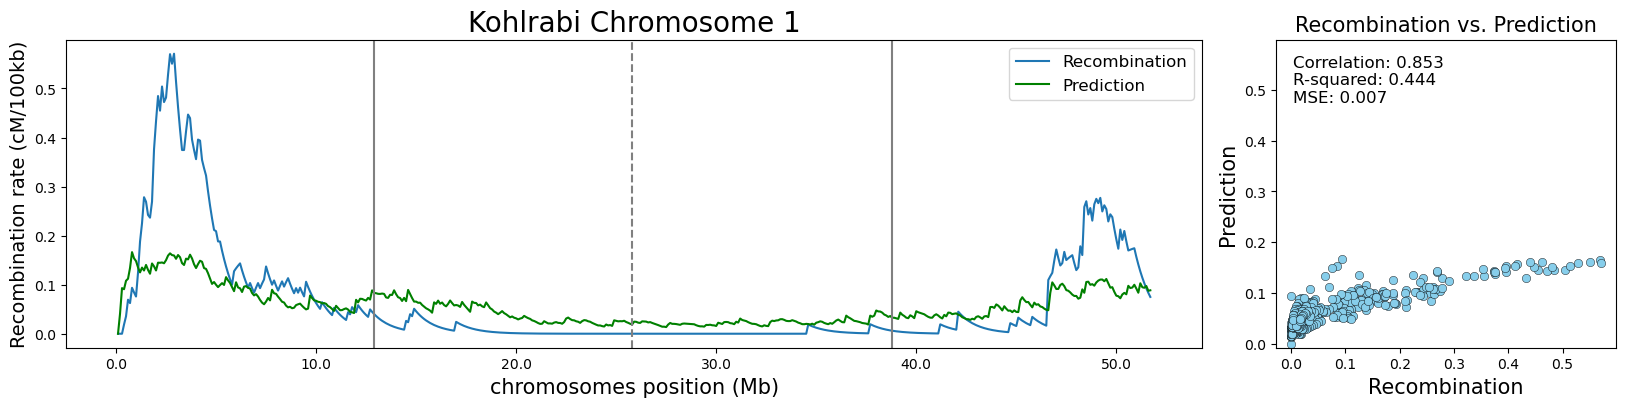

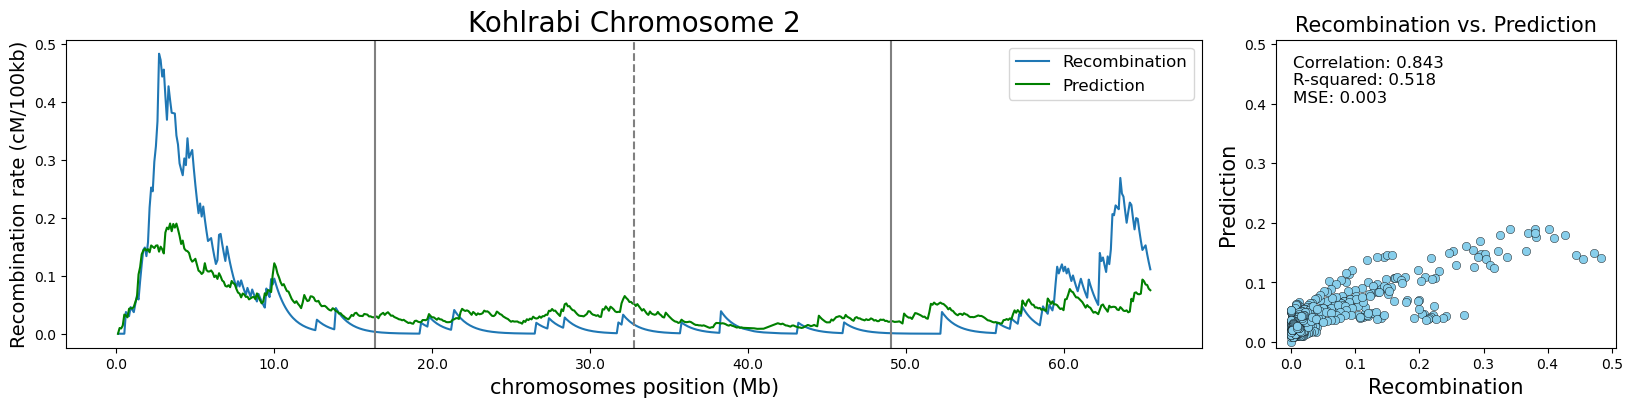

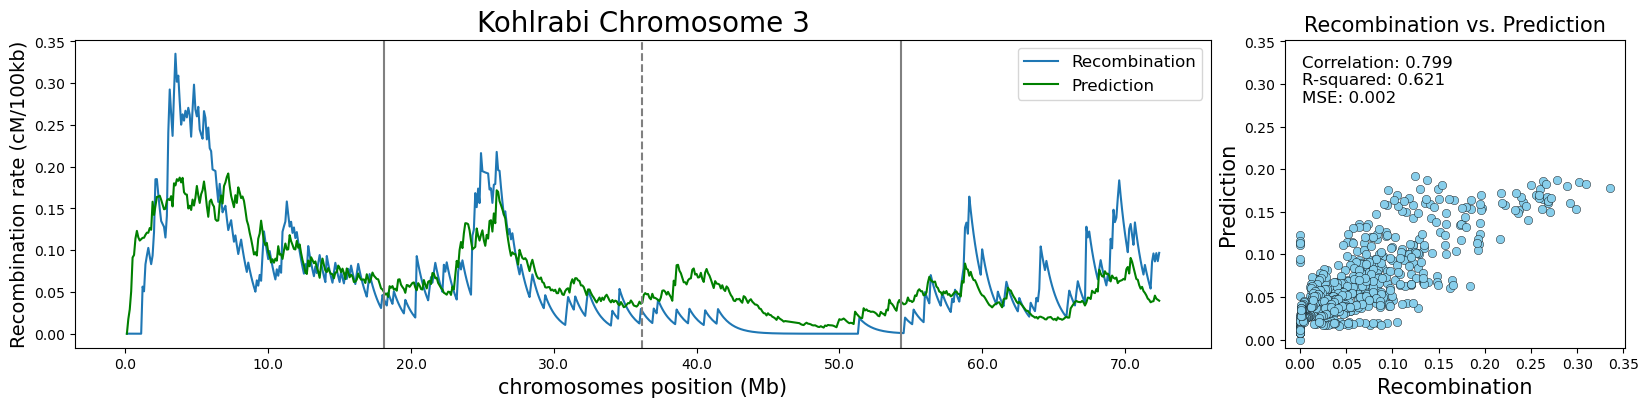

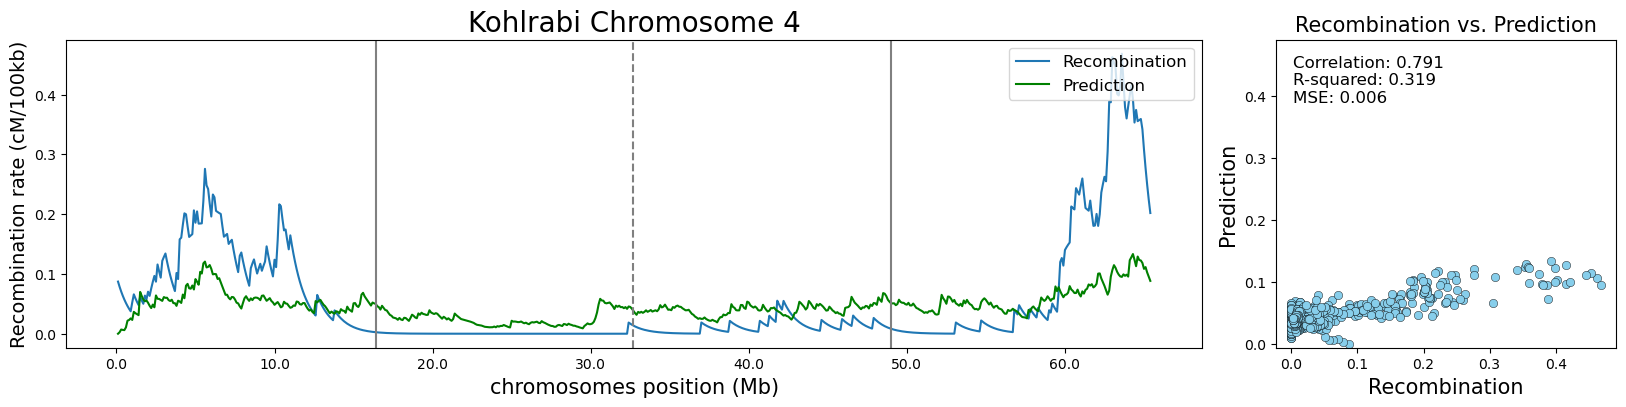

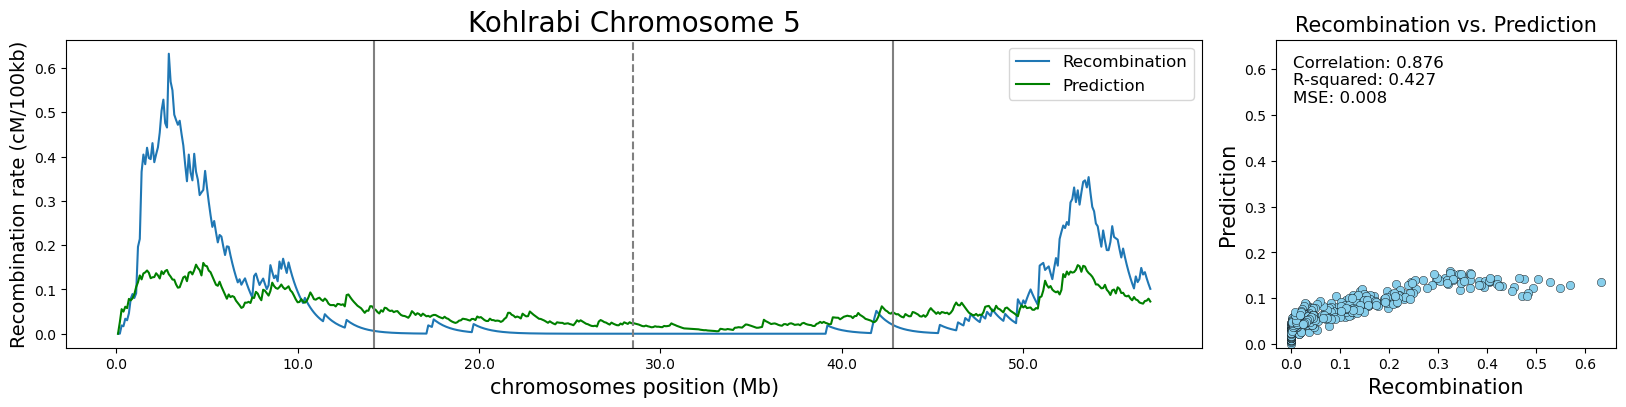

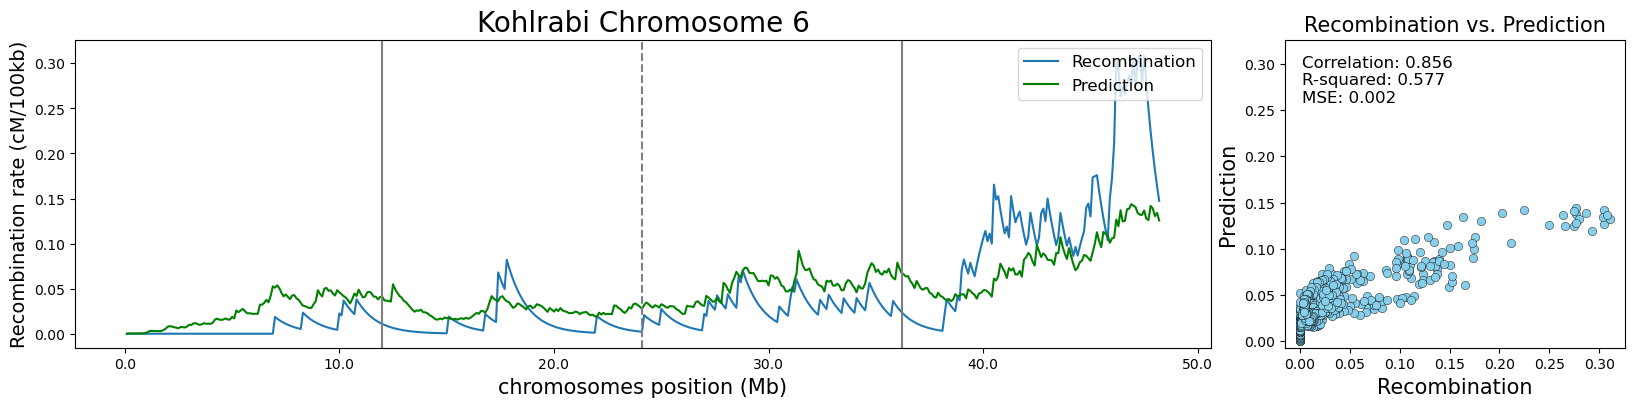

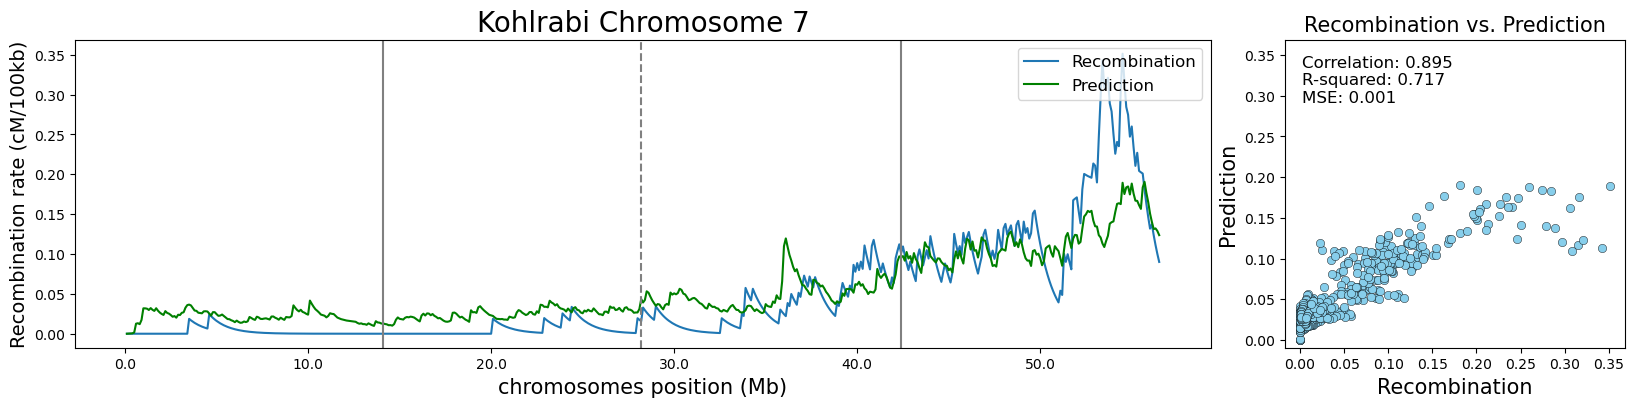

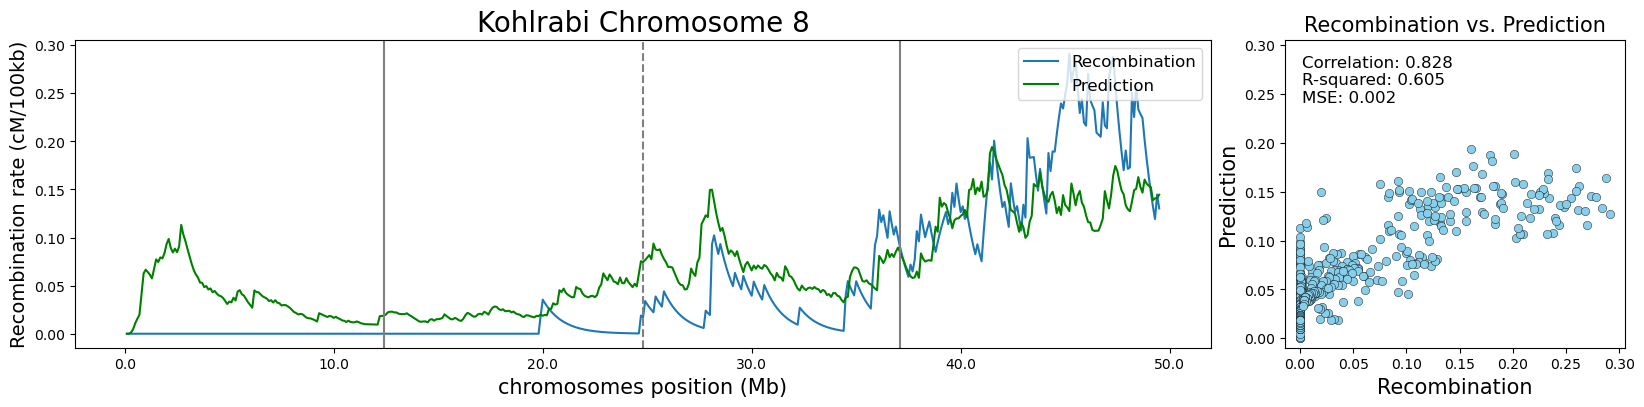

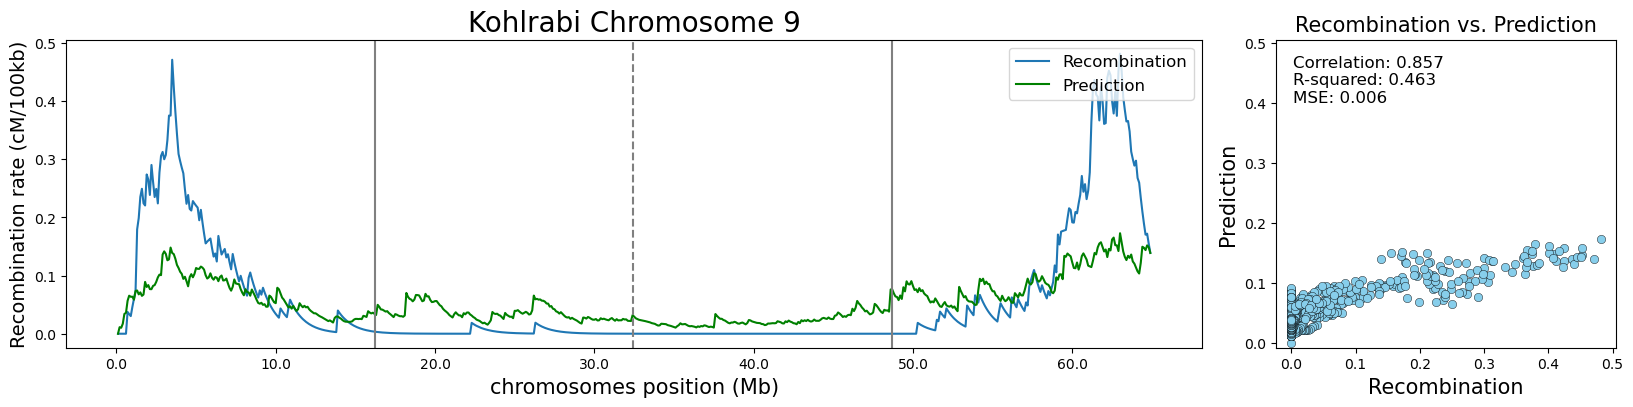

In [30]:
# Predictions and graphs for all chromosomes
for chr_number in range(1, 10):
    plot_chromosome_results(chr_number)
    plt.show()

# Data compilation

In [31]:
corr = pd.DataFrame({'corr':[corr_chr1, corr_chr2, corr_chr3, corr_chr4, corr_chr5, corr_chr6,corr_chr7,corr_chr8,corr_chr9,]})
r2 = pd.DataFrame({'R^2':[r2_chr1, r2_chr2, r2_chr3, r2_chr4, r2_chr5, r2_chr6, r2_chr7, r2_chr8, r2_chr9]})
mse = pd.DataFrame({'MSE':[mse_chr1, mse_chr2, mse_chr3, mse_chr4, mse_chr5, mse_chr6, mse_chr7, mse_chr8, mse_chr9]})
index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9',]})
tc_pko_table = pd.concat([index, corr, r2, mse], axis=1)
tc_pko_table

chr      corr       R^2       MSE
0  chr1  0.852981  0.444102  0.006981
1  chr2  0.843490  0.517575  0.003442
2  chr3  0.799120  0.620584  0.001516
3  chr4  0.790874  0.318769  0.005868
4  chr5  0.876318  0.427328  0.008401
5  chr6  0.855553  0.577460  0.001680
6  chr7  0.895296  0.717169  0.001313
7  chr8  0.828012  0.605389  0.002249
8  chr9  0.856728  0.463343  0.006316

Correlation between model predictions and recombination rates by quartiles

In [32]:
corr_q1 = pd.DataFrame({'Q1':[corr_q1_chr1,corr_q1_chr2,corr_q1_chr3,corr_q1_chr4,corr_q1_chr5,corr_q1_chr6,corr_q1_chr7,corr_q1_chr8,corr_q1_chr9]})
corr_q2 = pd.DataFrame({'Q2':[corr_q2_chr1,corr_q2_chr2,corr_q2_chr3,corr_q2_chr4,corr_q2_chr5,corr_q2_chr6,corr_q2_chr7,corr_q2_chr8,corr_q2_chr9]})
corr_q3 = pd.DataFrame({'Q3':[corr_q3_chr1,corr_q3_chr2,corr_q3_chr3,corr_q3_chr4,corr_q3_chr5,corr_q3_chr6,corr_q3_chr7,corr_q3_chr8,corr_q3_chr9]})
corr_q4 = pd.DataFrame({'Q4':[corr_q4_chr1,corr_q4_chr2,corr_q4_chr3,corr_q4_chr4,corr_q4_chr5,corr_q4_chr6,corr_q4_chr7,corr_q4_chr8,corr_q4_chr9]})

index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9']})
q_corr = pd.concat([index, corr_q1, corr_q2, corr_q3, corr_q4], axis=1)
q_corr_styled = q_corr.style.background_gradient(cmap="PRGn", vmin=-1, vmax=1)
q_corr_styled.set_table_styles([{'selector': 'th',
                                'props': [('text-align', 'center')]}])
q_corr_styled 

# Model trained with all Kohlrabi chromosomes to predict recombination on each Cauliflower chromosome

In [33]:
# TRAINING MODEL with Kohlrabi data
X_train = ko.drop(['cross', 'reference','chr','start','end','srec'], axis=1)
y_train = ko[['srec']]

model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=1)

In [34]:
# Objects with Cauliflower data per chromosome
chr1 = c[c['chr']== 'chr1']
chr2 = c[c['chr']== 'chr2']
chr3 = c[c['chr']== 'chr3']
chr4 = c[c['chr']== 'chr4']
chr5 = c[c['chr']== 'chr5']
chr6 = c[c['chr']== 'chr6']
chr7 = c[c['chr']== 'chr7']
chr8 = c[c['chr']== 'chr8']
chr9 = c[c['chr']== 'chr9']

In [35]:
def plot_chromosome_results(chr_number):
    # Replace  with 'chr{chr_number}' 
    chromosomes_data = globals()[f'achr{chr_number}']
    chr_data = globals()[f'chr{chr_number}']

    # MODEL PREDICTIONS
    model_preds = model.predict(chr_data.drop(['cross', 'reference','chr','start','end','srec'], axis=1))
    
    #SMOOTHING
    model_spreds= np.zeros(len(model_preds))

    for i in  range(1, len(model_preds)): 
        model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9
        
    #CORRELATIONS BY QUARTILES
    c_q1 = int(len(chr_data)*0.25)
    c_q2 = int(len(chr_data)*0.50)
    c_q3 = int(len(chr_data)*0.75)
    
    rq1 = chr_data['srec'].iloc[0:c_q1]
    rq2 = chr_data['srec'].iloc[c_q1:c_q2]
    rq3 = chr_data['srec'].iloc[c_q2:c_q3]
    rq4 = chr_data['srec'].iloc[c_q3:int(len(chr_data))]

    pq1 = model_spreds[0:c_q1]
    pq2 = model_spreds[c_q1:c_q2]
    pq3 = model_spreds[c_q2:c_q3]
    pq4 = model_spreds[c_q3:int(len(chr_data))]

    corr_q1 = np.corrcoef(rq1, pq1)[0, 1]
    corr_q2 = np.corrcoef(rq2, pq2)[0, 1]
    corr_q3 = np.corrcoef(rq3, pq3)[0, 1]
    corr_q4 = np.corrcoef(rq4, pq4)[0, 1]
    
    globals()[f'corr_q1_chr{chr_number}'] = corr_q1
    globals()[f'corr_q2_chr{chr_number}'] = corr_q2
    globals()[f'corr_q3_chr{chr_number}'] = corr_q3
    globals()[f'corr_q4_chr{chr_number}'] = corr_q4
     
    # PLOTTING RESULTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw={'width_ratios': [10, 3]})

    # Line plot and correlation plot
    ax1.plot(chr_data.end, chr_data.srec, label='Recombination')
    ax1.plot(chr_data.end, model_spreds, label='Prediction', color='green')
    ax1.set_title(f'Cauliflower Chromosome {chr_number}', fontsize=20)
    ax1.set_xlabel('chromosomes position (Mb)', fontsize=15)
    ax1.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
    ax1.legend(loc='upper right', fontsize=12)
    ticks = ax1.get_xticks() / 1000000
    ax1.set_xticklabels(ticks)
        
    chr_len = chr_data["end"].iloc[-1]
    q1 =round(chr_len * 0.25 / 100000) * 100000
    q2 =round(chr_len* 0.50 / 100000) * 100000
    q3 =round(chr_len * 0.75 / 100000) * 100000

    ax1.axvline(x=q1, color='gray', linestyle='-')
    ax1.axvline(x=q2, color='gray', linestyle='--')
    ax1.axvline(x=q3, color='gray', linestyle='-')

    # Scatter plot
    scatter = ax2.scatter(chr_data.srec, model_spreds, c='skyblue', edgecolors='black', linewidth= 0.3)
    ax2.set_title('Recombination vs. Prediction', fontsize=15)
    ax2.set_xlabel('Recombination', fontsize=15)
    ax2.set_ylabel('Prediction', fontsize=15)

    # Calculate correlation coefficient, coefficient of determination, and Mean Squared Error
    corr_chr = np.corrcoef(chr_data.srec, model_spreds)[0, 1]
    r2_chr = r2_score(chr_data.srec, model_spreds)
    mse_chr = mean_squared_error(chr_data.srec, model_spreds)

    # Calculate the aspect ratio based on the plot heights
    h1 = ax1.get_ylim()
    h2 = ax2.get_ylim()
    aspect_ratio = max(h1[1] - h1[0], h2[1] - h2[0]) / (max(h1[1], h2[1]) - min(h1[0], h2[0]))

    # Set the aspect ratio for the scatter plot only if it doesn't distort the square shape
    if aspect_ratio < 1:
        ax2.set_aspect('equal')

    # Display correlation coefficient, coefficient of determination, and Mean Squared Error as plain text
    globals()[f'corr_chr{chr_number}'] = corr_chr
    globals()[f'r2_chr{chr_number}'] = r2_chr
    globals()[f'mse_chr{chr_number}'] = mse_chr

    textstr = f'Correlation: {corr_chr:.3f}\nR-squared: {r2_chr:.3f}\nMSE: {mse_chr:.3f}'
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

    # Adjustments to align the heights of the two plots
    max_height = max(h1[1], h2[1])
    ax1.set_ylim([h1[0], max_height])
    ax2.set_ylim([h2[0], max_height])

    # Reduce the separation between the plots
    plt.subplots_adjust(wspace=0.1)
    plt.show()

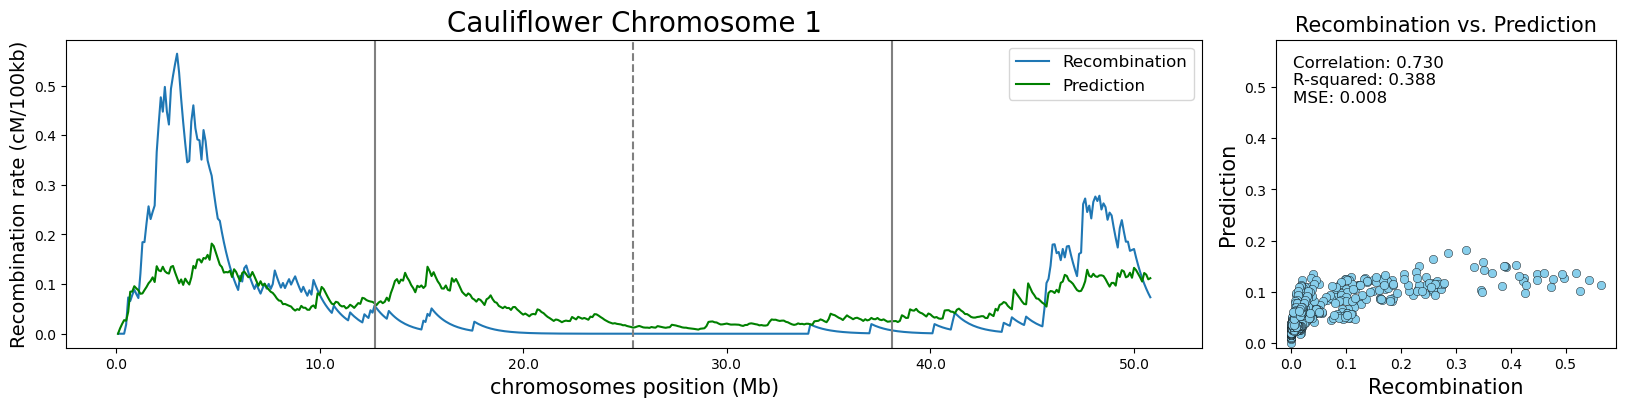

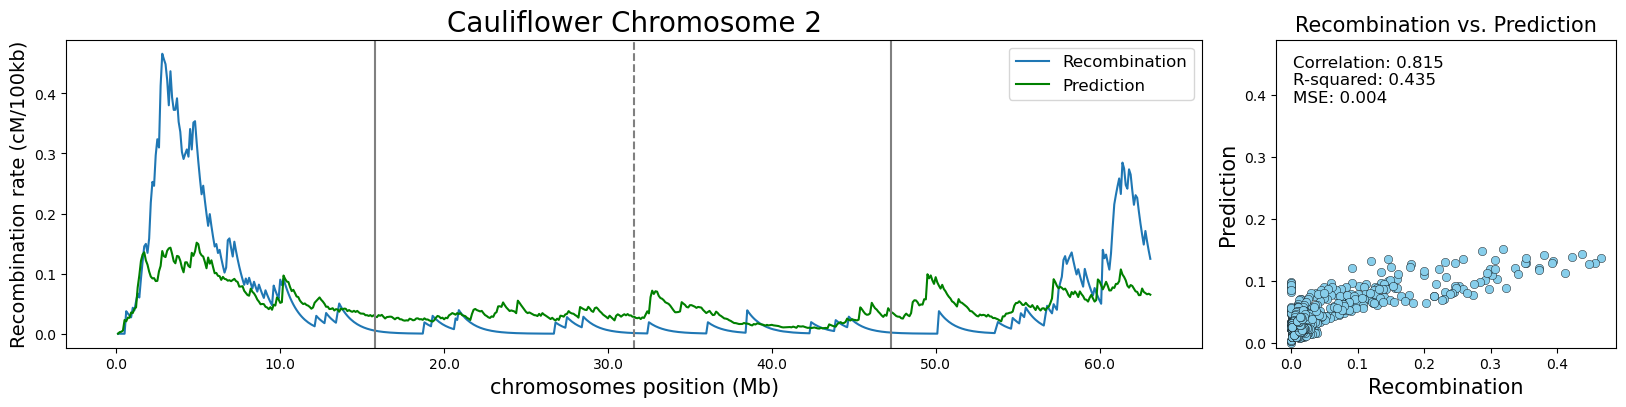

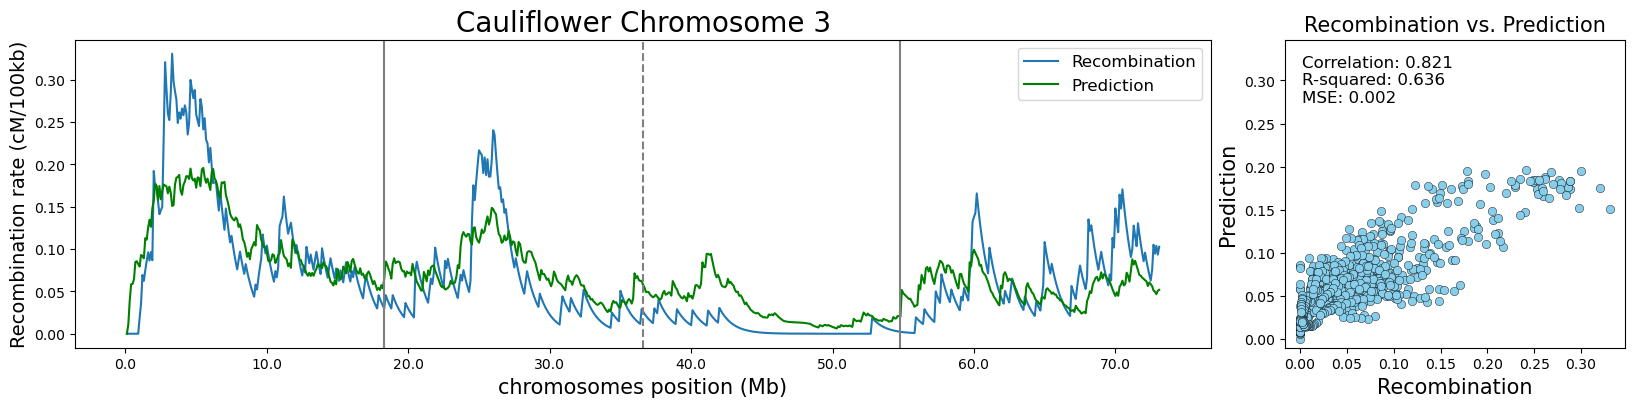

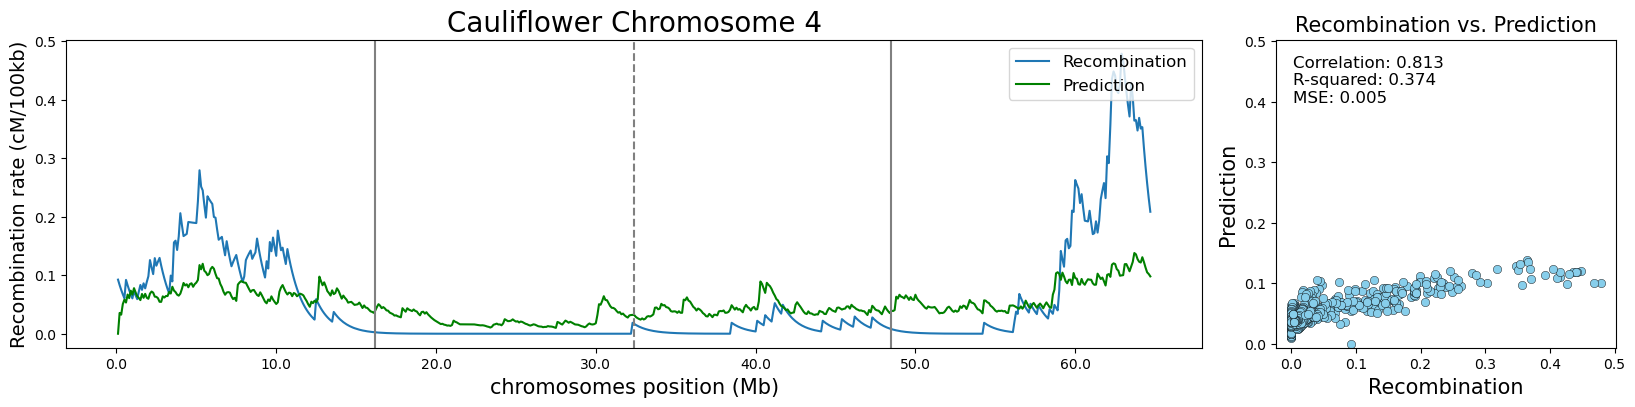

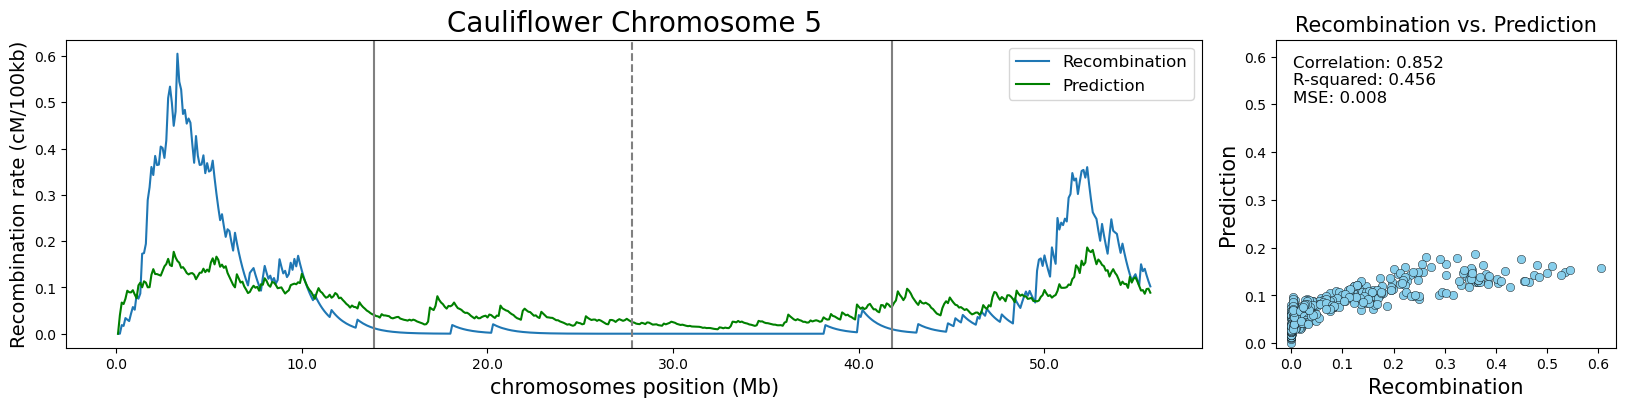

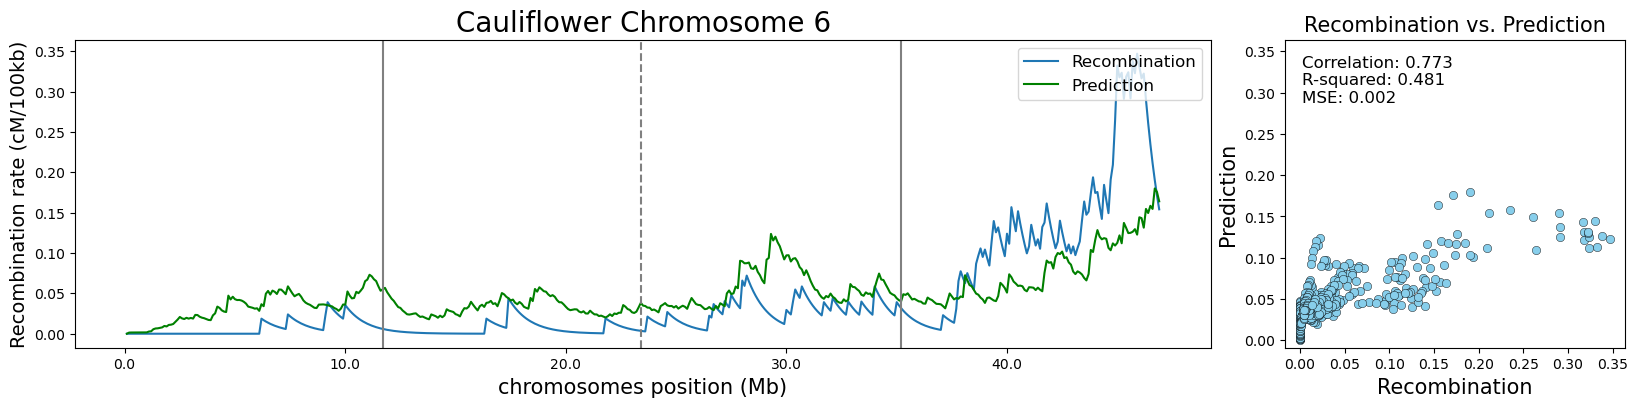

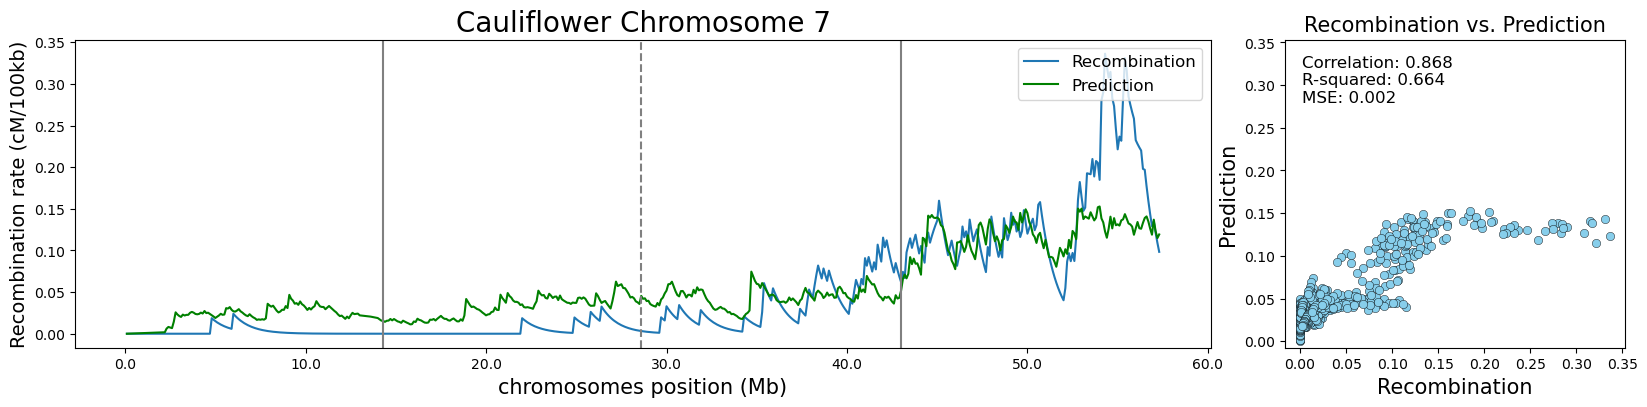

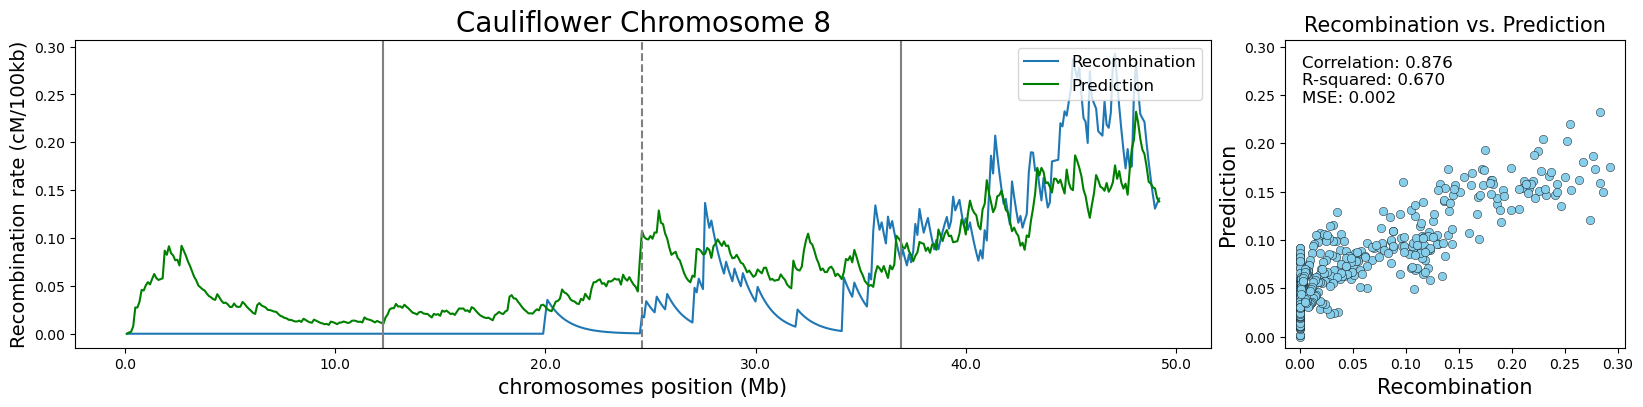

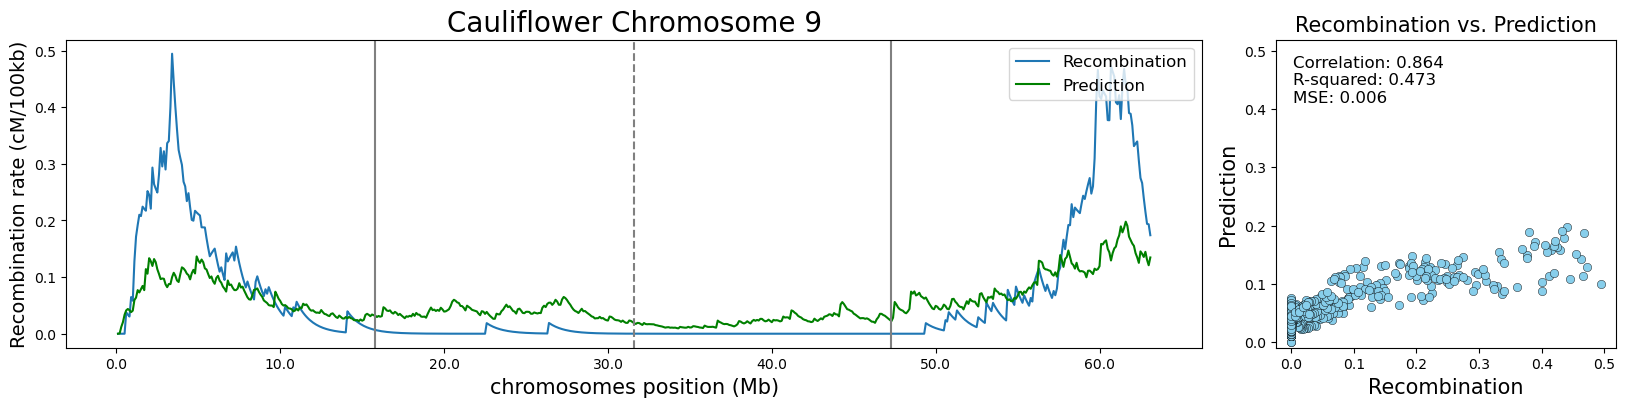

In [36]:
# Predictions and graphs for all chromosomes
for chr_number in range(1, 10):
    plot_chromosome_results(chr_number)
    plt.show()

# Data compilation

In [37]:
corr = pd.DataFrame({'corr':[corr_chr1, corr_chr2, corr_chr3, corr_chr4, corr_chr5, corr_chr6,corr_chr7,corr_chr8,corr_chr9,]})
r2 = pd.DataFrame({'R^2':[r2_chr1, r2_chr2, r2_chr3, r2_chr4, r2_chr5, r2_chr6, r2_chr7, r2_chr8, r2_chr9]})
mse = pd.DataFrame({'MSE':[mse_chr1, mse_chr2, mse_chr3, mse_chr4, mse_chr5, mse_chr6, mse_chr7, mse_chr8, mse_chr9]})
index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9',]})
tko_pc_table = pd.concat([index, corr, r2, mse], axis=1)
tko_pc_table

chr      corr       R^2       MSE
0  chr1  0.729806  0.387731  0.007572
1  chr2  0.814550  0.435421  0.004286
2  chr3  0.820796  0.636257  0.001561
3  chr4  0.812889  0.374467  0.005482
4  chr5  0.851626  0.456155  0.007983
5  chr6  0.773314  0.480521  0.002458
6  chr7  0.868273  0.663628  0.001607
7  chr8  0.875773  0.669891  0.001862
8  chr9  0.864226  0.473349  0.006420

Correlation between model predictions and recombination rates by quartiles

In [38]:
corr_q1 = pd.DataFrame({'Q1':[corr_q1_chr1,corr_q1_chr2,corr_q1_chr3,corr_q1_chr4,corr_q1_chr5,corr_q1_chr6,corr_q1_chr7,corr_q1_chr8,corr_q1_chr9]})
corr_q2 = pd.DataFrame({'Q2':[corr_q2_chr1,corr_q2_chr2,corr_q2_chr3,corr_q2_chr4,corr_q2_chr5,corr_q2_chr6,corr_q2_chr7,corr_q2_chr8,corr_q2_chr9]})
corr_q3 = pd.DataFrame({'Q3':[corr_q3_chr1,corr_q3_chr2,corr_q3_chr3,corr_q3_chr4,corr_q3_chr5,corr_q3_chr6,corr_q3_chr7,corr_q3_chr8,corr_q3_chr9]})
corr_q4 = pd.DataFrame({'Q4':[corr_q4_chr1,corr_q4_chr2,corr_q4_chr3,corr_q4_chr4,corr_q4_chr5,corr_q4_chr6,corr_q4_chr7,corr_q4_chr8,corr_q4_chr9]})

index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9']})
q_corr = pd.concat([index, corr_q1, corr_q2, corr_q3, corr_q4], axis=1)
q_corr_styled = q_corr.style.background_gradient(cmap="PRGn", vmin=-1, vmax=1)
q_corr_styled.set_table_styles([{'selector': 'th',
                                'props': [('text-align', 'center')]}])
q_corr_styled 

# Four model comparison

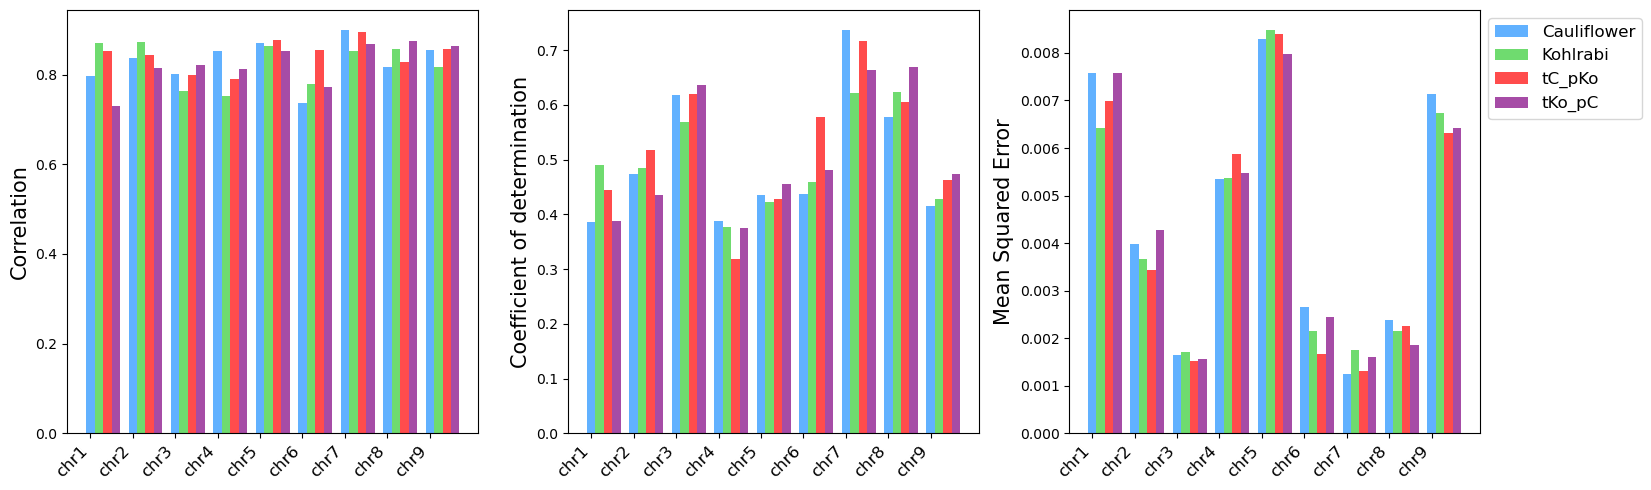

In [39]:
# Adjusting bar width
bar_width = 0.2

# Creating data positions
bar_positions_c = np.arange(len(c_table['chr']))
bar_positions_ko = bar_positions_c + bar_width
bar_positions_tc_pko = bar_positions_ko + bar_width
bar_positions_tko_pc = bar_positions_tc_pko + bar_width

# Creating subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First chart
axs[0].bar(bar_positions_c, c_table['corr'], color='dodgerblue', width=bar_width, label='Cauliflower', alpha=0.7)
axs[0].bar(bar_positions_ko, ko_table['corr'], color='limegreen', width=bar_width, label='Kohlrabi', alpha=0.7)
axs[0].bar(bar_positions_tc_pko, tc_pko_table['corr'], color='red', width=bar_width, label='tC_pKo', alpha=0.7)
axs[0].bar(bar_positions_tko_pc, tko_pc_table['corr'], color='purple', width=bar_width, label='tKo_pC', alpha=0.7)

axs[0].set_ylabel('Correlation', fontsize=15)

# Second chart

axs[1].bar(bar_positions_c, c_table['R^2'], color='dodgerblue', width=bar_width, label='Cauliflower', alpha=0.7)
axs[1].bar(bar_positions_ko, ko_table['R^2'], color='limegreen', width=bar_width, label='Kohlrabi', alpha=0.7)
axs[1].bar(bar_positions_tc_pko, tc_pko_table['R^2'], color='red', width=bar_width, label='tC_pKo', alpha=0.7)
axs[1].bar(bar_positions_tko_pc, tko_pc_table['R^2'], color='purple', width=bar_width, label='tKo_pC', alpha=0.7)

axs[1].set_ylabel('Coefficient of determination', fontsize=15)

# Third chart

axs[2].bar(bar_positions_c, c_table['MSE'], color='dodgerblue', width=bar_width, label='Cauliflower', alpha=0.7)
axs[2].bar(bar_positions_ko, ko_table['MSE'], color='limegreen', width=bar_width, label='Kohlrabi', alpha=0.7)
axs[2].bar(bar_positions_tc_pko, tc_pko_table['MSE'], color='red', width=bar_width, label='tC_pKo', alpha=0.7)
axs[2].bar(bar_positions_tko_pc, tko_pc_table['MSE'], color='purple', width=bar_width, label='tKo_pC', alpha=0.7)

axs[2].set_ylabel('Mean Squared Error', fontsize=15)

# Get chromosome labels from the 'chr' column
chr_labels = c_table['chr']

# Set x-axis labels for all three subplots
for ax in axs:
    ax.set_xticks(bar_positions_c)
    ax.set_xticklabels(chr_labels)

# Rotate labels for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Adjusting layout
plt.tight_layout()

# Place legend outside the subplots and above the last subplot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Show the figure
plt.show()

# Model trained with information from Brassica crosses to predict recombination on each Cauliflower chromosome

In [40]:
study.head(2)

cross reference   chr   start     end  srec  gene  mRNA  \
0  broccoli_cauliflower  broccoli  chr1       0  100000   0.0    22    22   
1  broccoli_cauliflower  broccoli  chr1  100000  200000   0.0    27    27   

   exon  CDS  
0    91   91  
1   135  135

In [41]:
all_info_without_cauliflower = study[study['reference'] != 'cauliflower' ]
all_info_without_cauliflower

cross reference   chr     start       end      srec  \
0       broccoli_cauliflower  broccoli  chr1         0    100000  0.000000   
1       broccoli_cauliflower  broccoli  chr1    100000    200000  0.000000   
2       broccoli_cauliflower  broccoli  chr1    200000    300000  0.000000   
3       broccoli_cauliflower  broccoli  chr1    300000    400000  0.036497   
4       broccoli_cauliflower  broccoli  chr1    400000    500000  0.032847   
...                      ...       ...   ...       ...       ...       ...   
103831        white_kohlrabi  kohlrabi  chr9  64400000  64500000  0.189701   
103832        white_kohlrabi  kohlrabi  chr9  64500000  64600000  0.170731   
103833        white_kohlrabi  kohlrabi  chr9  64600000  64700000  0.153658   
103834        white_kohlrabi  kohlrabi  chr9  64700000  64800000  0.138292   
103835        white_kohlrabi  kohlrabi  chr9  64800000  64900000  0.124463   

        gene  mRNA  exon  CDS  
0         22    22    91   91  
1         27    27   135  135  
2         15    15    66   66  
3         26    26    87   87  
4         22    22    90   90  
...      ...   ...   ...  ...  
103831    13    13    76   76  
103832    16    16    77   77  
103833    22    22   112  112  
103834    11    11    49   49  
103835    16    16    77   77  

[83240 rows x 10 columns]

In [42]:
all_info_without_cauliflower.reference.unique()

array(['broccoli', 'kohlrabi', 'kale', 'white'], dtype=object)

In [43]:
# TRAINING MODEL WITH BRASSICA CROSSES
X_train = all_info_without_cauliflower.drop(['cross', 'reference','chr','start','end','srec'], axis=1)
y_train = all_info_without_cauliflower[['srec']]

model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=1)

In [44]:
# Objects with Cauliflower data per chromosome
chr1 = c[c['chr']== 'chr1']
chr2 = c[c['chr']== 'chr2']
chr3 = c[c['chr']== 'chr3']
chr4 = c[c['chr']== 'chr4']
chr5 = c[c['chr']== 'chr5']
chr6 = c[c['chr']== 'chr6']
chr7 = c[c['chr']== 'chr7']
chr8 = c[c['chr']== 'chr8']
chr9 = c[c['chr']== 'chr9']

In [45]:
def plot_chromosome_results(chr_number):
    # Replace  with 'chr{chr_number}' 
    chromosomes_data = globals()[f'achr{chr_number}']
    chr_data = globals()[f'chr{chr_number}']

    # MODEL PREDICTIONS
    model_preds = model.predict(chr_data.drop(['cross', 'reference','chr','start','end','srec'], axis=1))
    
    #SMOOTHING
    model_spreds= np.zeros(len(model_preds))

    for i in  range(1, len(model_preds)): 
        model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9
        
    #CORRELATIONS BY QUARTILES
    c_q1 = int(len(chr_data)*0.25)
    c_q2 = int(len(chr_data)*0.50)
    c_q3 = int(len(chr_data)*0.75)
    
    rq1 = chr_data['srec'].iloc[0:c_q1]
    rq2 = chr_data['srec'].iloc[c_q1:c_q2]
    rq3 = chr_data['srec'].iloc[c_q2:c_q3]
    rq4 = chr_data['srec'].iloc[c_q3:int(len(chr_data))]

    pq1 = model_spreds[0:c_q1]
    pq2 = model_spreds[c_q1:c_q2]
    pq3 = model_spreds[c_q2:c_q3]
    pq4 = model_spreds[c_q3:int(len(chr_data))]

    corr_q1 = np.corrcoef(rq1, pq1)[0, 1]
    corr_q2 = np.corrcoef(rq2, pq2)[0, 1]
    corr_q3 = np.corrcoef(rq3, pq3)[0, 1]
    corr_q4 = np.corrcoef(rq4, pq4)[0, 1]
    
    globals()[f'corr_q1_chr{chr_number}'] = corr_q1
    globals()[f'corr_q2_chr{chr_number}'] = corr_q2
    globals()[f'corr_q3_chr{chr_number}'] = corr_q3
    globals()[f'corr_q4_chr{chr_number}'] = corr_q4
     
    # PLOTTING RESULTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw={'width_ratios': [10, 3]})

    # Line plot and correlation plot
    ax1.plot(chr_data.end, chr_data.srec, label='Recombination')
    ax1.plot(chr_data.end, model_spreds, label='Prediction', color='green')
    ax1.set_title(f'Cauliflower Chromosome {chr_number}', fontsize=20)
    ax1.set_xlabel('chromosomes position (Mb)', fontsize=15)
    ax1.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
    ax1.legend(loc='upper right', fontsize=12)
    ticks = ax1.get_xticks() / 1000000
    ax1.set_xticklabels(ticks)
        
    chr_len = chr_data["end"].iloc[-1]
    q1 =round(chr_len * 0.25 / 100000) * 100000
    q2 =round(chr_len* 0.50 / 100000) * 100000
    q3 =round(chr_len * 0.75 / 100000) * 100000

    ax1.axvline(x=q1, color='gray', linestyle='-')
    ax1.axvline(x=q2, color='gray', linestyle='--')
    ax1.axvline(x=q3, color='gray', linestyle='-')

    # Scatter plot
    scatter = ax2.scatter(chr_data.srec, model_spreds, c='skyblue', edgecolors='black', linewidth= 0.3)
    ax2.set_title('Recombination vs. Prediction', fontsize=15)
    ax2.set_xlabel('Recombination', fontsize=15)
    ax2.set_ylabel('Prediction', fontsize=15)

    # Calculate correlation coefficient, coefficient of determination, and Mean Squared Error
    corr_chr = np.corrcoef(chr_data.srec, model_spreds)[0, 1]
    r2_chr = r2_score(chr_data.srec, model_spreds)
    mse_chr = mean_squared_error(chr_data.srec, model_spreds)

    # Calculate the aspect ratio based on the plot heights
    h1 = ax1.get_ylim()
    h2 = ax2.get_ylim()
    aspect_ratio = max(h1[1] - h1[0], h2[1] - h2[0]) / (max(h1[1], h2[1]) - min(h1[0], h2[0]))

    # Set the aspect ratio for the scatter plot only if it doesn't distort the square shape
    if aspect_ratio < 1:
        ax2.set_aspect('equal')

    # Display correlation coefficient, coefficient of determination, and Mean Squared Error as plain text
    globals()[f'corr_chr{chr_number}'] = corr_chr
    globals()[f'r2_chr{chr_number}'] = r2_chr
    globals()[f'mse_chr{chr_number}'] = mse_chr

    textstr = f'Correlation: {corr_chr:.3f}\nR-squared: {r2_chr:.3f}\nMSE: {mse_chr:.3f}'
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

    # Adjustments to align the heights of the two plots
    max_height = max(h1[1], h2[1])
    ax1.set_ylim([h1[0], max_height])
    ax2.set_ylim([h2[0], max_height])

    # Reduce the separation between the plots
    plt.subplots_adjust(wspace=0.1)
    plt.show()

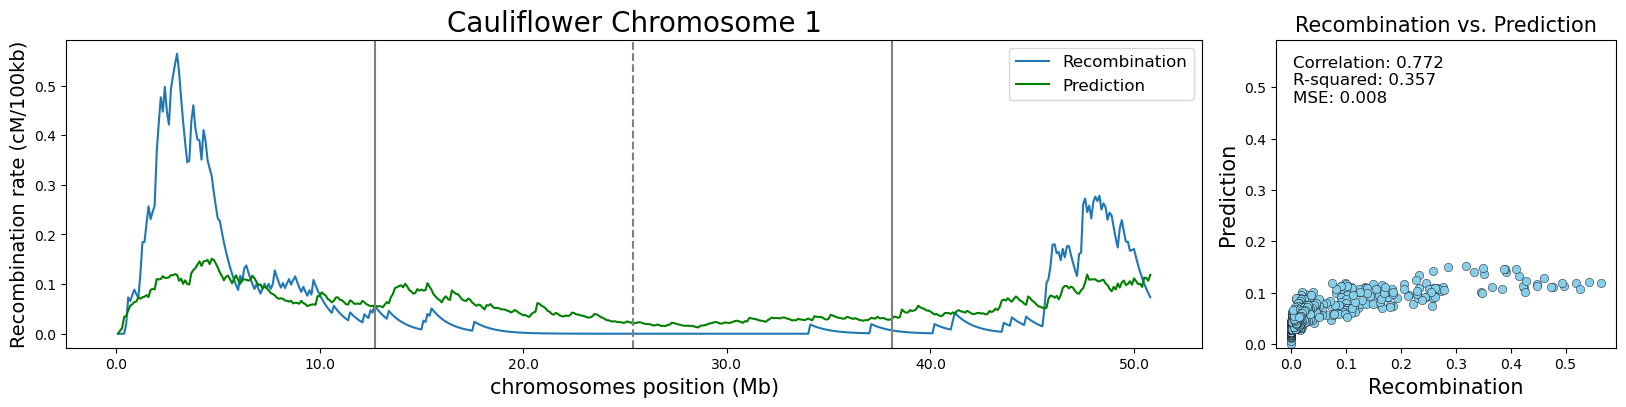

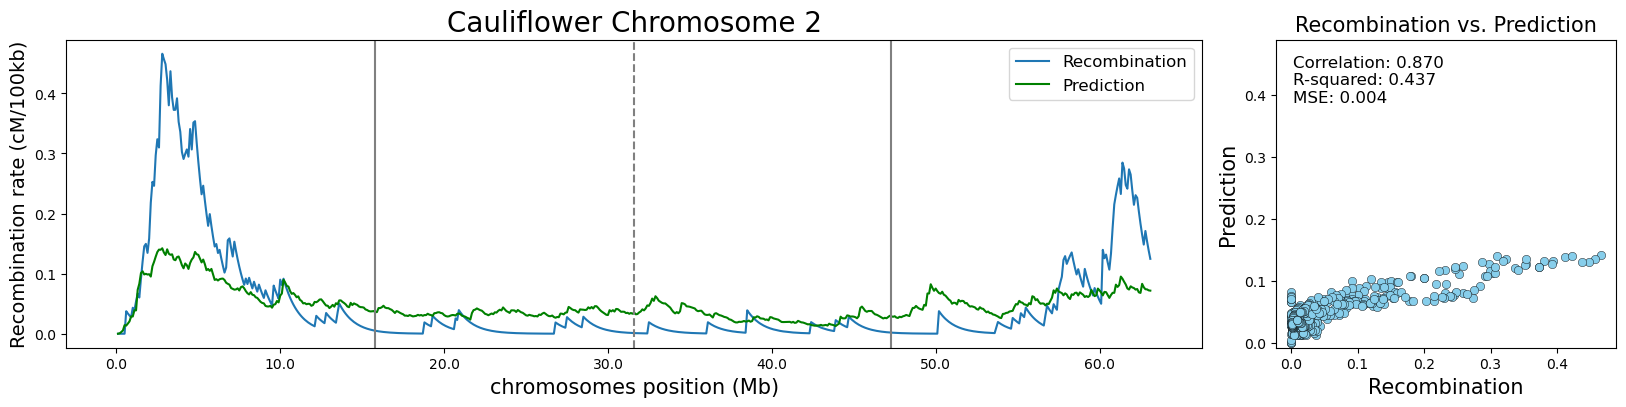

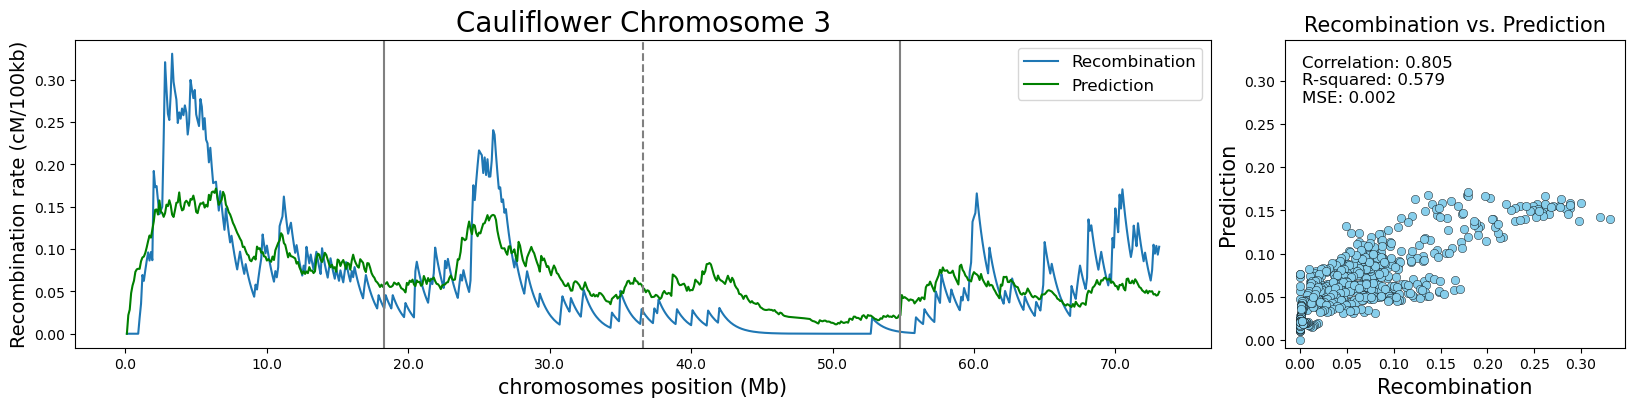

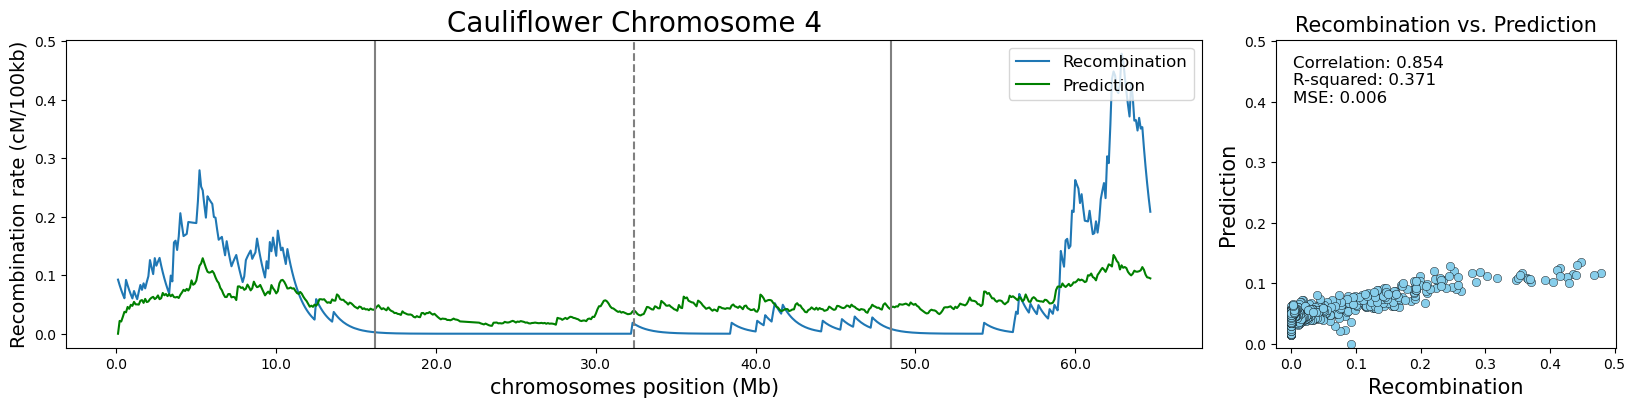

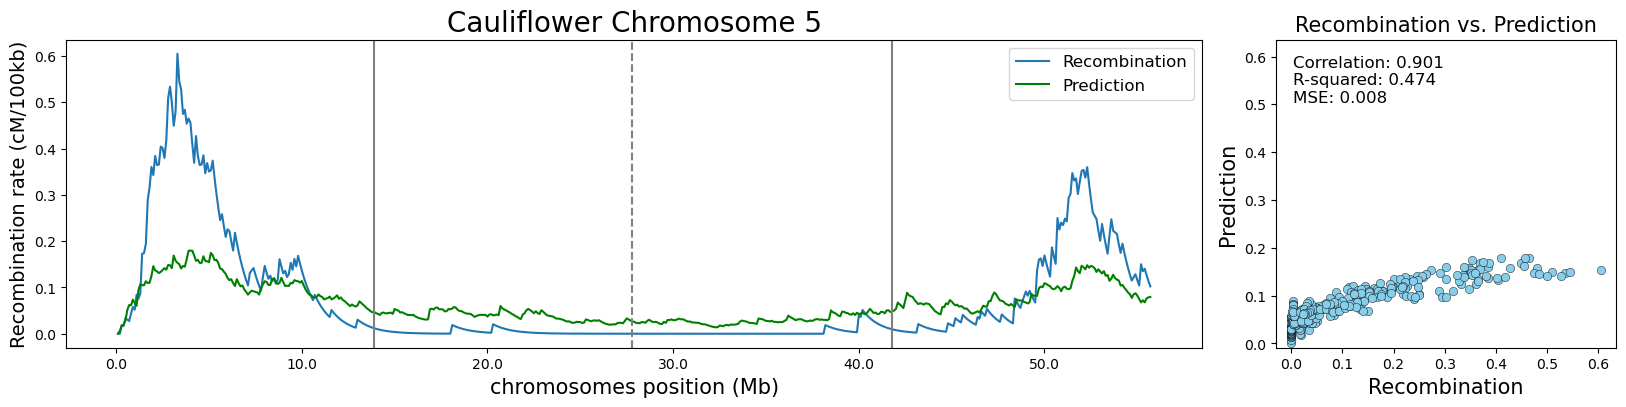

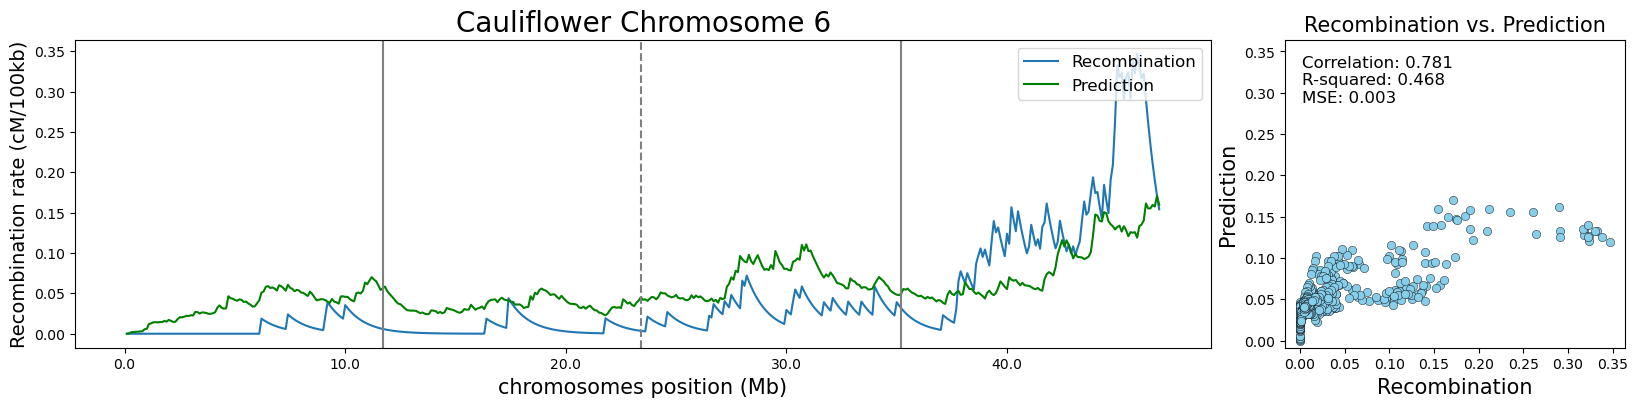

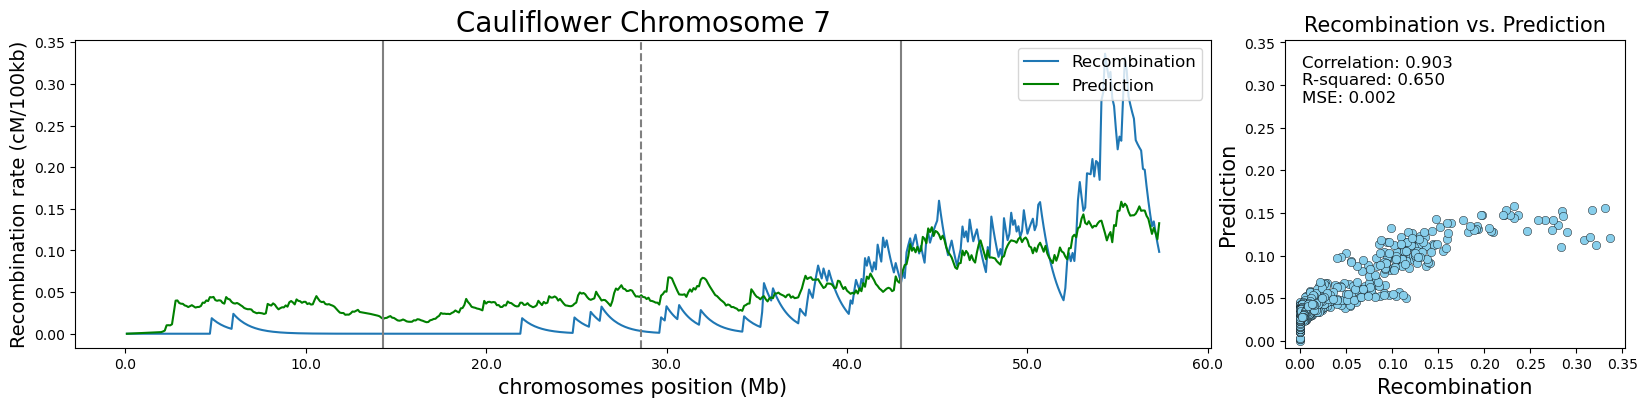

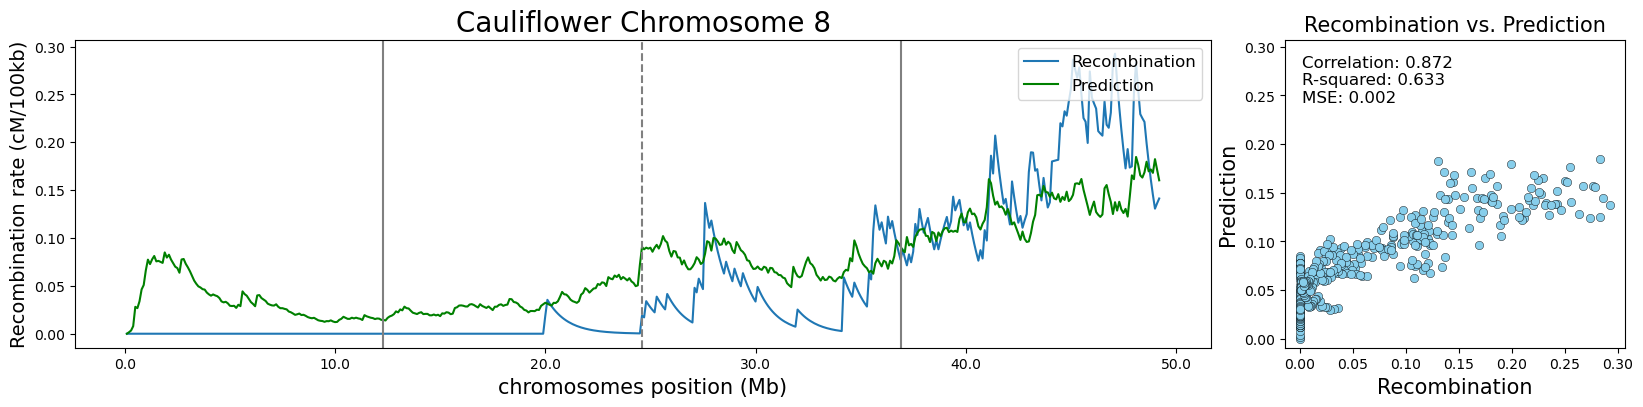

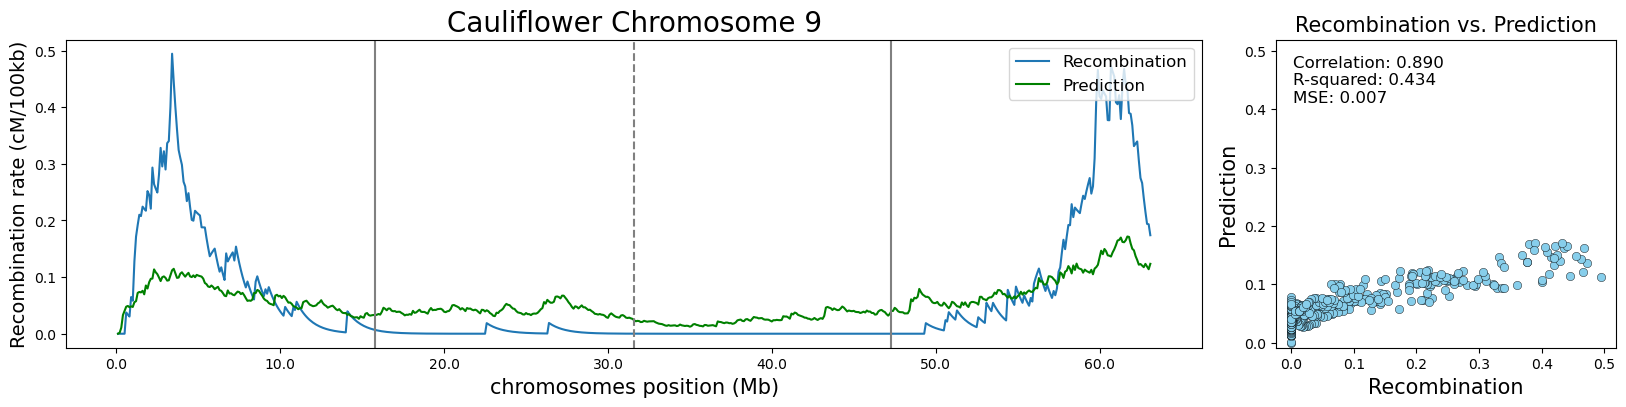

In [46]:
# Predictions and graphs for all chromosomes
for chr_number in range(1, 10):
    plot_chromosome_results(chr_number)
    plt.show()

# Data compilation

In [47]:
corr = pd.DataFrame({'corr':[corr_chr1, corr_chr2, corr_chr3, corr_chr4, corr_chr5, corr_chr6,corr_chr7,corr_chr8,corr_chr9,]})
r2 = pd.DataFrame({'R^2':[r2_chr1, r2_chr2, r2_chr3, r2_chr4, r2_chr5, r2_chr6, r2_chr7, r2_chr8, r2_chr9]})
mse = pd.DataFrame({'MSE':[mse_chr1, mse_chr2, mse_chr3, mse_chr4, mse_chr5, mse_chr6, mse_chr7, mse_chr8, mse_chr9]})
index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9',]})
ta_pc_table = pd.concat([index, corr, r2, mse], axis=1)
ta_pc_table

chr      corr       R^2       MSE
0  chr1  0.772020  0.356717  0.007956
1  chr2  0.870438  0.436568  0.004277
2  chr3  0.805285  0.579367  0.001805
3  chr4  0.854204  0.371147  0.005512
4  chr5  0.900594  0.473528  0.007728
5  chr6  0.780550  0.468059  0.002517
6  chr7  0.903455  0.650427  0.001670
7  chr8  0.872486  0.632543  0.002072
8  chr9  0.889553  0.434396  0.006894

In [48]:
corr_q1 = pd.DataFrame({'Q1':[corr_q1_chr1,corr_q1_chr2,corr_q1_chr3,corr_q1_chr4,corr_q1_chr5,corr_q1_chr6,corr_q1_chr7,corr_q1_chr8,corr_q1_chr9]})
corr_q2 = pd.DataFrame({'Q2':[corr_q2_chr1,corr_q2_chr2,corr_q2_chr3,corr_q2_chr4,corr_q2_chr5,corr_q2_chr6,corr_q2_chr7,corr_q2_chr8,corr_q2_chr9]})
corr_q3 = pd.DataFrame({'Q3':[corr_q3_chr1,corr_q3_chr2,corr_q3_chr3,corr_q3_chr4,corr_q3_chr5,corr_q3_chr6,corr_q3_chr7,corr_q3_chr8,corr_q3_chr9]})
corr_q4 = pd.DataFrame({'Q4':[corr_q4_chr1,corr_q4_chr2,corr_q4_chr3,corr_q4_chr4,corr_q4_chr5,corr_q4_chr6,corr_q4_chr7,corr_q4_chr8,corr_q4_chr9]})

index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9']})
q_corr = pd.concat([index, corr_q1, corr_q2, corr_q3, corr_q4], axis=1)
q_corr_styled = q_corr.style.background_gradient(cmap="PRGn", vmin=-1, vmax=1)
q_corr_styled.set_table_styles([{'selector': 'th',
                                'props': [('text-align', 'center')]}])
q_corr_styled 

# Model trained with information from Brassica crosses to predict recombination on each Kohlrabi chromosome

In [49]:
all_info_without_kohlrabi = study[study['reference'] != 'kohlrabi' ]
all_info_without_kohlrabi

cross reference   chr     start       end      srec  \
0      broccoli_cauliflower  broccoli  chr1         0    100000  0.000000   
1      broccoli_cauliflower  broccoli  chr1    100000    200000  0.000000   
2      broccoli_cauliflower  broccoli  chr1    200000    300000  0.000000   
3      broccoli_cauliflower  broccoli  chr1    300000    400000  0.036497   
4      broccoli_cauliflower  broccoli  chr1    400000    500000  0.032847   
...                     ...       ...   ...       ...       ...       ...   
98622        white_kohlrabi     white  chr9  65200000  65300000  0.164241   
98623        white_kohlrabi     white  chr9  65300000  65400000  0.174133   
98624        white_kohlrabi     white  chr9  65400000  65500000  0.156719   
98625        white_kohlrabi     white  chr9  65500000  65600000  0.141047   
98626        white_kohlrabi     white  chr9  65600000  65700000  0.126943   

       gene  mRNA  exon  CDS  
0        22    22    91   91  
1        27    27   135  135  
2        15    15    66   66  
3        26    26    87   87  
4        22    22    90   90  
...     ...   ...   ...  ...  
98622     5     5    17   17  
98623    18    18    91   91  
98624    19    19   106  106  
98625    18    18    82   82  
98626     8     8    37   37  

[82980 rows x 10 columns]

In [50]:
all_info_without_kohlrabi.reference.unique()

array(['broccoli', 'cauliflower', 'kale', 'white'], dtype=object)

In [51]:
# TRAINING MODEL WITH BRASSICA CROSSES
X_train = all_info_without_kohlrabi.drop(['cross', 'reference','chr','start','end','srec'], axis=1)
y_train = all_info_without_kohlrabi[['srec']]

model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=1)

In [52]:
# Objects with Kohlrabi data per chromosome
chr1 = ko[ko['chr']== 'chr1']
chr2 = ko[ko['chr']== 'chr3']
chr4 = ko[ko['chr']== 'chr4']
chr5 = ko[ko['chr']== 'chr5']
chr6 = ko[ko['chr']== 'chr6']
chr7 = ko[ko['chr']== 'chr7']
chr8 = ko[ko['chr']== 'chr8']
chr9 = ko[ko['chr']== 'chr9']

In [53]:
def plot_chromosome_results(chr_number):
    # Replace  with 'chr{chr_number}' 
    chromosomes_data = globals()[f'achr{chr_number}']
    chr_data = globals()[f'chr{chr_number}']

    # MODEL PREDICTIONS
    model_preds = model.predict(chr_data.drop(['cross', 'reference','chr','start','end','srec'], axis=1))
    
    #SMOOTHING
    model_spreds= np.zeros(len(model_preds))

    for i in  range(1, len(model_preds)): 
        model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9
        
    #CORRELATIONS BY QUARTILES
    c_q1 = int(len(chr_data)*0.25)
    c_q2 = int(len(chr_data)*0.50)
    c_q3 = int(len(chr_data)*0.75)
    
    rq1 = chr_data['srec'].iloc[0:c_q1]
    rq2 = chr_data['srec'].iloc[c_q1:c_q2]
    rq3 = chr_data['srec'].iloc[c_q2:c_q3]
    rq4 = chr_data['srec'].iloc[c_q3:int(len(chr_data))]

    pq1 = model_spreds[0:c_q1]
    pq2 = model_spreds[c_q1:c_q2]
    pq3 = model_spreds[c_q2:c_q3]
    pq4 = model_spreds[c_q3:int(len(chr_data))]

    corr_q1 = np.corrcoef(rq1, pq1)[0, 1]
    corr_q2 = np.corrcoef(rq2, pq2)[0, 1]
    corr_q3 = np.corrcoef(rq3, pq3)[0, 1]
    corr_q4 = np.corrcoef(rq4, pq4)[0, 1]
    
    globals()[f'corr_q1_chr{chr_number}'] = corr_q1
    globals()[f'corr_q2_chr{chr_number}'] = corr_q2
    globals()[f'corr_q3_chr{chr_number}'] = corr_q3
    globals()[f'corr_q4_chr{chr_number}'] = corr_q4
     
    # PLOTTING RESULTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw={'width_ratios': [10, 3]})

    # Line plot and correlation plot
    ax1.plot(chr_data.end, chr_data.srec, label='Recombination')
    ax1.plot(chr_data.end, model_spreds, label='Prediction', color='green')
    ax1.set_title(f'Kohlrabi Chromosome {chr_number}', fontsize=20)
    ax1.set_xlabel('chromosomes position (Mb)', fontsize=15)
    ax1.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
    ax1.legend(loc='upper right', fontsize=12)
    ticks = ax1.get_xticks() / 1000000
    ax1.set_xticklabels(ticks)
        
    chr_len = chr_data["end"].iloc[-1]
    q1 =round(chr_len * 0.25 / 100000) * 100000
    q2 =round(chr_len* 0.50 / 100000) * 100000
    q3 =round(chr_len * 0.75 / 100000) * 100000

    ax1.axvline(x=q1, color='gray', linestyle='-')
    ax1.axvline(x=q2, color='gray', linestyle='--')
    ax1.axvline(x=q3, color='gray', linestyle='-')

    # Scatter plot
    scatter = ax2.scatter(chr_data.srec, model_spreds, c='skyblue', edgecolors='black', linewidth= 0.3)
    ax2.set_title('Recombination vs. Prediction', fontsize=15)
    ax2.set_xlabel('Recombination', fontsize=15)
    ax2.set_ylabel('Prediction', fontsize=15)

    # Calculate correlation coefficient, coefficient of determination, and Mean Squared Error
    corr_chr = np.corrcoef(chr_data.srec, model_spreds)[0, 1]
    r2_chr = r2_score(chr_data.srec, model_spreds)
    mse_chr = mean_squared_error(chr_data.srec, model_spreds)

    # Calculate the aspect ratio based on the plot heights
    h1 = ax1.get_ylim()
    h2 = ax2.get_ylim()
    aspect_ratio = max(h1[1] - h1[0], h2[1] - h2[0]) / (max(h1[1], h2[1]) - min(h1[0], h2[0]))

    # Set the aspect ratio for the scatter plot only if it doesn't distort the square shape
    if aspect_ratio < 1:
        ax2.set_aspect('equal')

    # Display correlation coefficient, coefficient of determination, and Mean Squared Error as plain text
    globals()[f'corr_chr{chr_number}'] = corr_chr
    globals()[f'r2_chr{chr_number}'] = r2_chr
    globals()[f'mse_chr{chr_number}'] = mse_chr

    textstr = f'Correlation: {corr_chr:.3f}\nR-squared: {r2_chr:.3f}\nMSE: {mse_chr:.3f}'
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

    # Adjustments to align the heights of the two plots
    max_height = max(h1[1], h2[1])
    ax1.set_ylim([h1[0], max_height])
    ax2.set_ylim([h2[0], max_height])

    # Reduce the separation between the plots
    plt.subplots_adjust(wspace=0.1)
    plt.show()

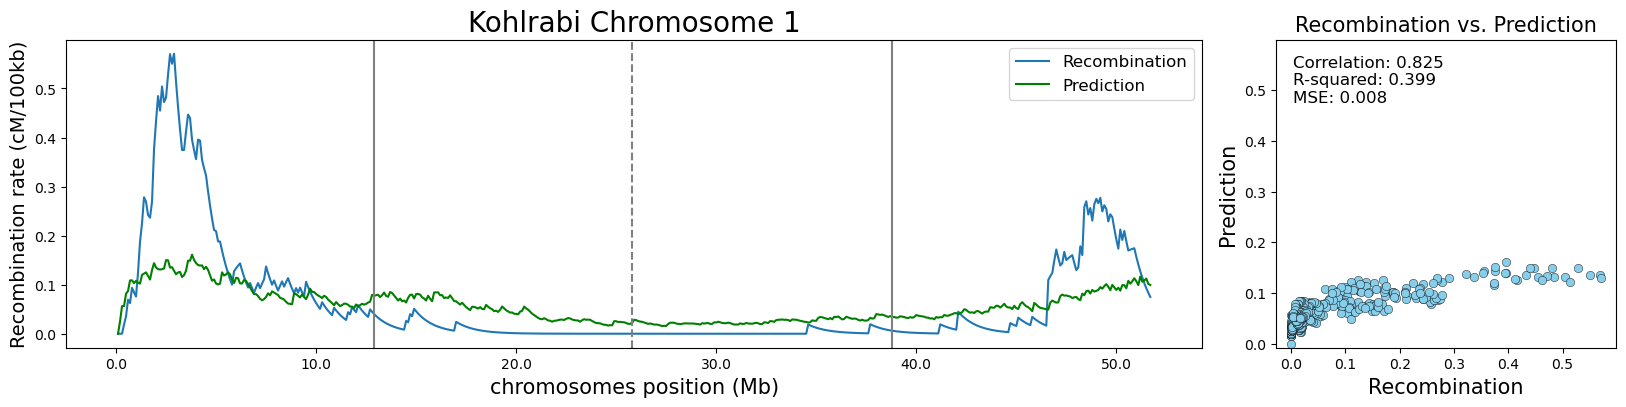

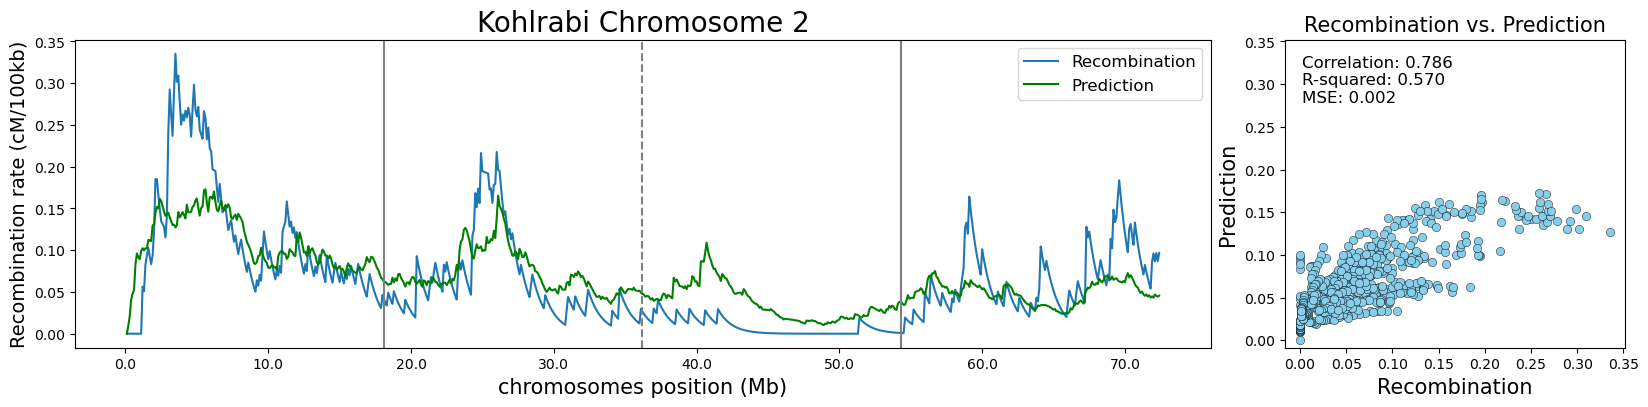

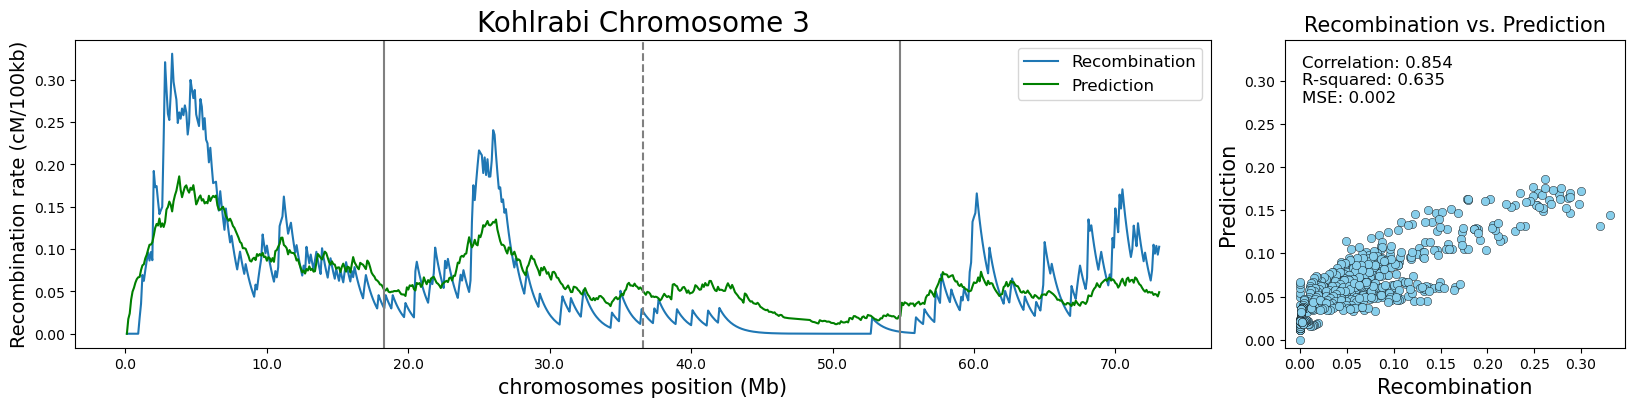

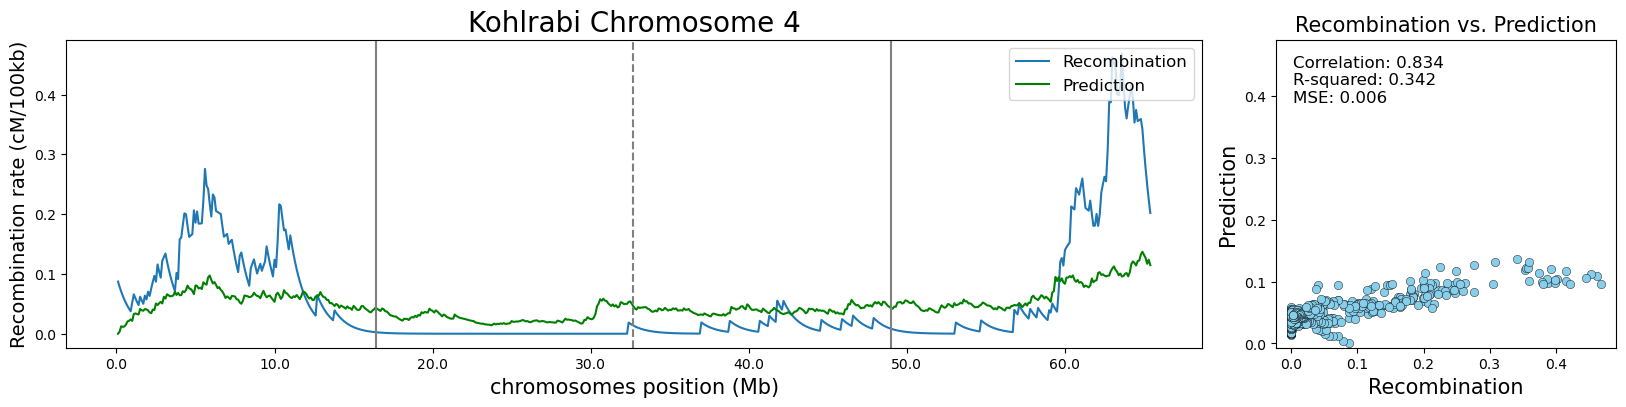

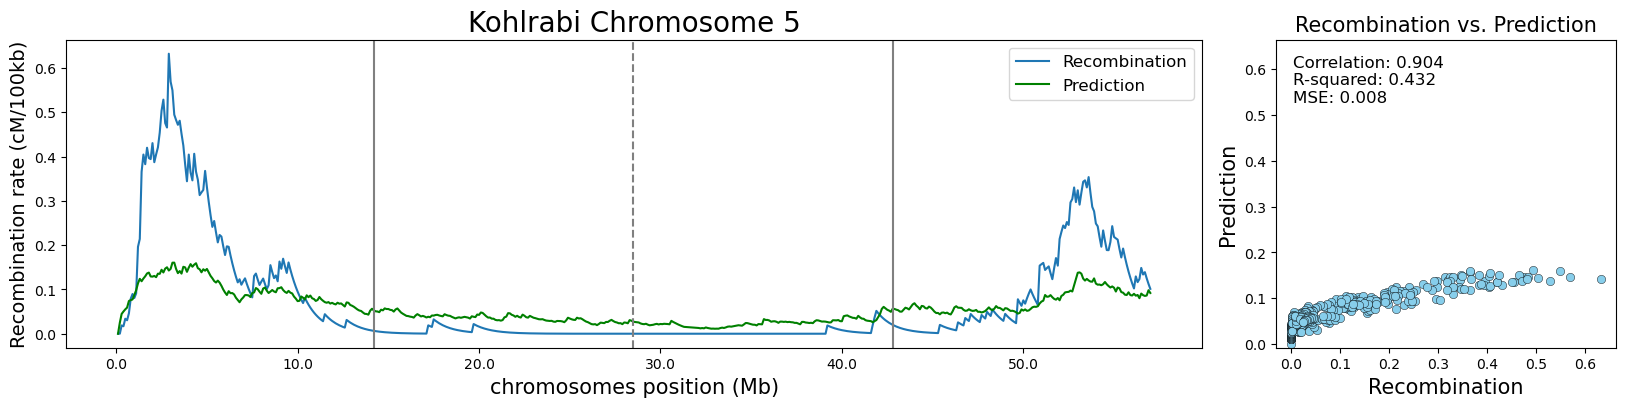

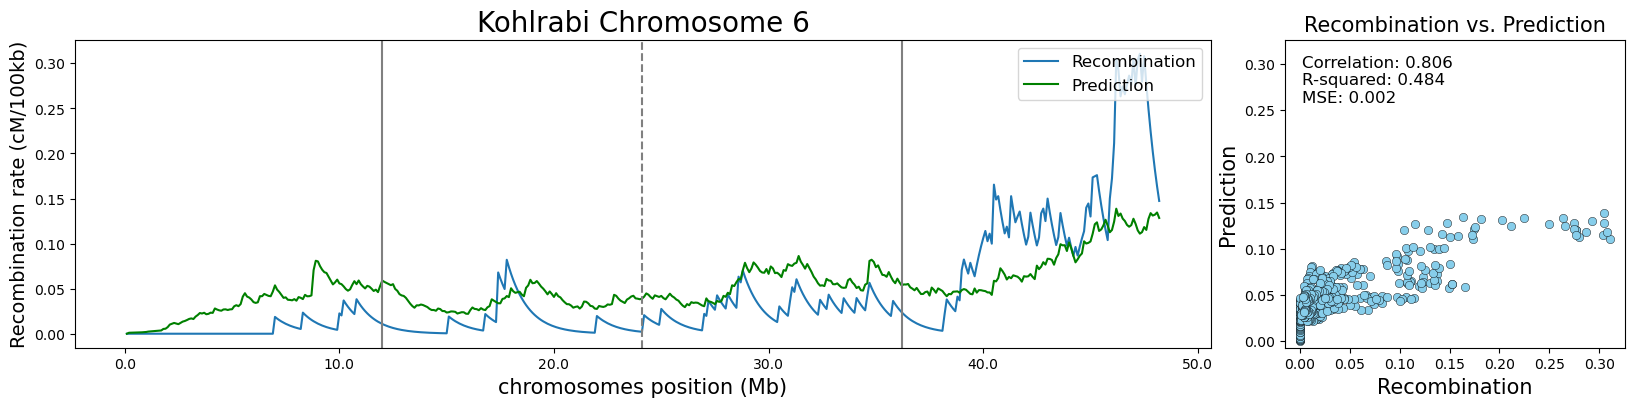

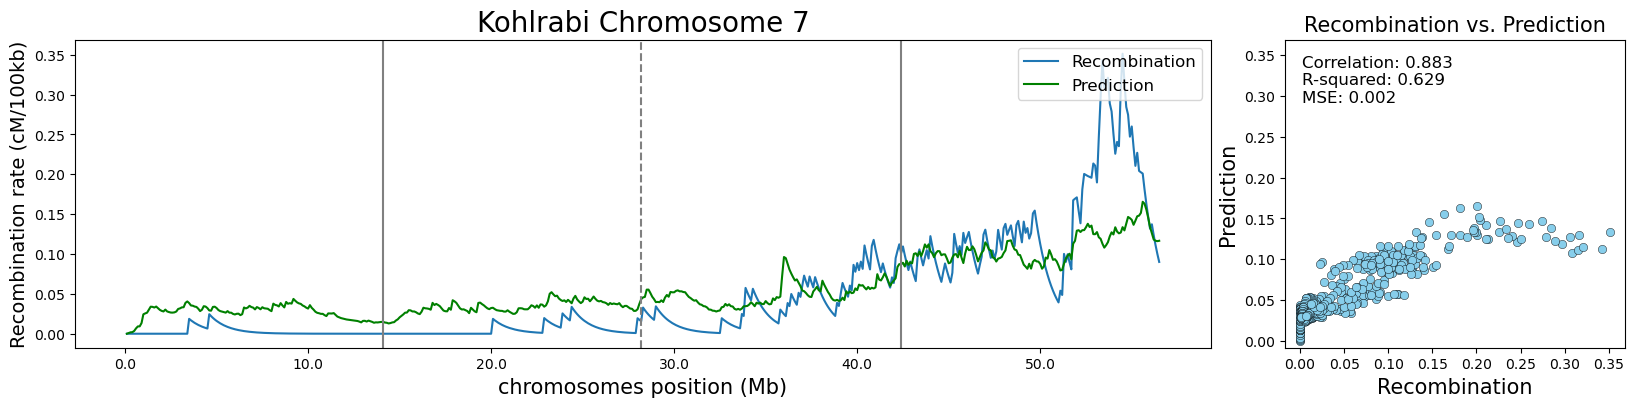

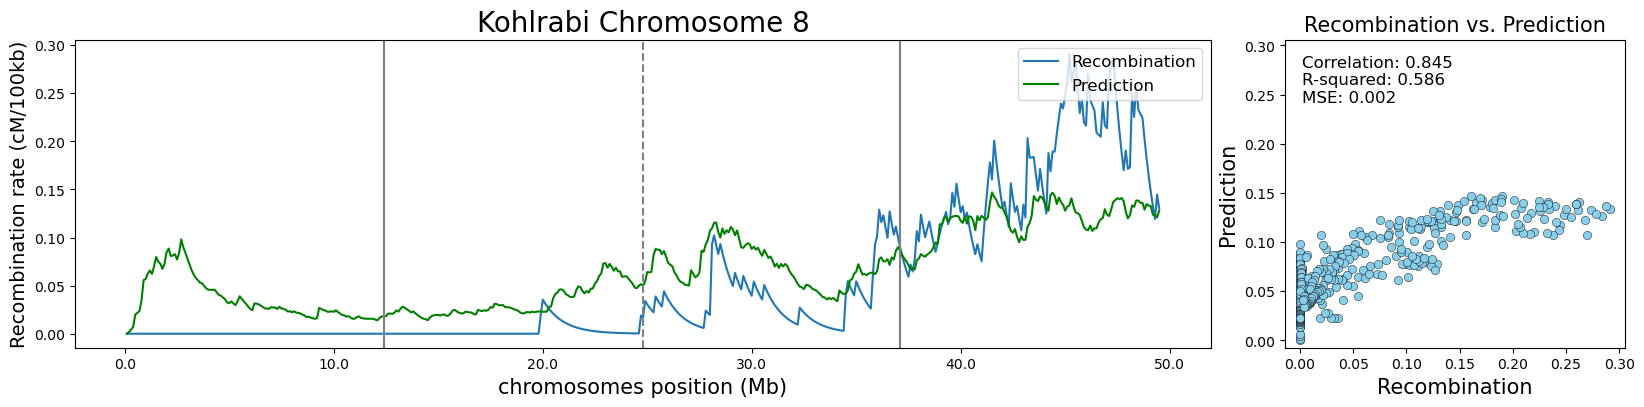

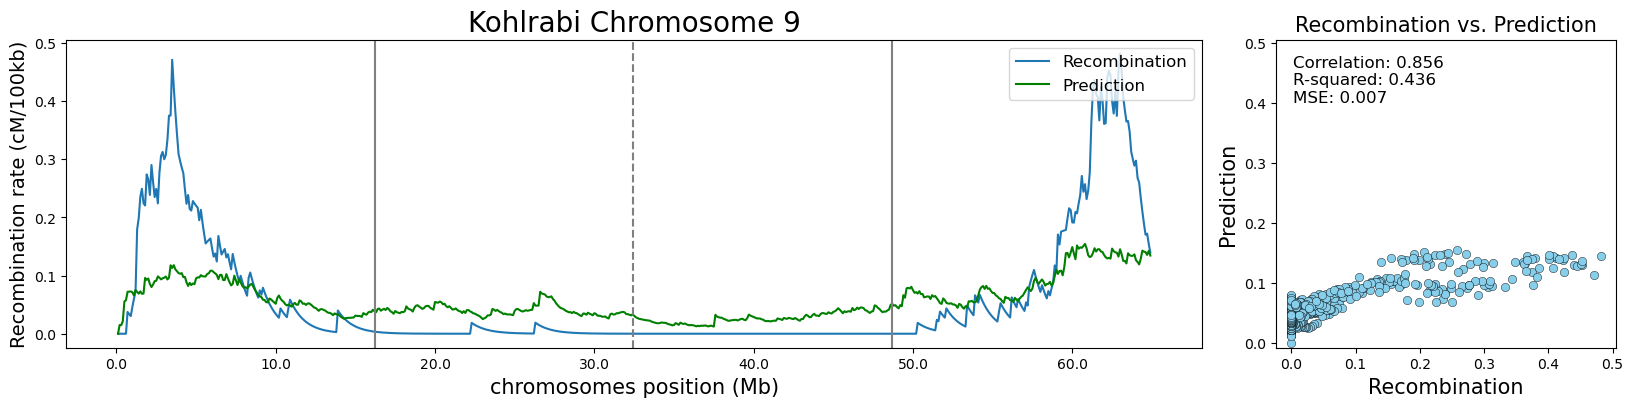

In [54]:
# Predictions and graphs for all chromosomes
for chr_number in range(1, 10):
    plot_chromosome_results(chr_number)
    plt.show()

# Data compilation

In [55]:
corr = pd.DataFrame({'corr':[corr_chr1, corr_chr2, corr_chr3, corr_chr4, corr_chr5, corr_chr6,corr_chr7,corr_chr8,corr_chr9,]})
r2 = pd.DataFrame({'R^2':[r2_chr1, r2_chr2, r2_chr3, r2_chr4, r2_chr5, r2_chr6, r2_chr7, r2_chr8, r2_chr9]})
mse = pd.DataFrame({'MSE':[mse_chr1, mse_chr2, mse_chr3, mse_chr4, mse_chr5, mse_chr6, mse_chr7, mse_chr8, mse_chr9]})
index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9',]})
ta_pko_table = pd.concat([index, corr, r2, mse], axis=1)
ta_pko_table

chr      corr       R^2       MSE
0  chr1  0.825387  0.399428  0.007542
1  chr2  0.785629  0.569719  0.001719
2  chr3  0.853543  0.635094  0.001566
3  chr4  0.834140  0.341668  0.005670
4  chr5  0.904380  0.432269  0.008329
5  chr6  0.805768  0.484480  0.002049
6  chr7  0.882540  0.629497  0.001720
7  chr8  0.845143  0.586444  0.002357
8  chr9  0.856238  0.436032  0.006638

In [56]:
corr_q1 = pd.DataFrame({'Q1':[corr_q1_chr1,corr_q1_chr2,corr_q1_chr3,corr_q1_chr4,corr_q1_chr5,corr_q1_chr6,corr_q1_chr7,corr_q1_chr8,corr_q1_chr9]})
corr_q2 = pd.DataFrame({'Q2':[corr_q2_chr1,corr_q2_chr2,corr_q2_chr3,corr_q2_chr4,corr_q2_chr5,corr_q2_chr6,corr_q2_chr7,corr_q2_chr8,corr_q2_chr9]})
corr_q3 = pd.DataFrame({'Q3':[corr_q3_chr1,corr_q3_chr2,corr_q3_chr3,corr_q3_chr4,corr_q3_chr5,corr_q3_chr6,corr_q3_chr7,corr_q3_chr8,corr_q3_chr9]})
corr_q4 = pd.DataFrame({'Q4':[corr_q4_chr1,corr_q4_chr2,corr_q4_chr3,corr_q4_chr4,corr_q4_chr5,corr_q4_chr6,corr_q4_chr7,corr_q4_chr8,corr_q4_chr9]})

index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9']})
q_corr = pd.concat([index, corr_q1, corr_q2, corr_q3, corr_q4], axis=1)
q_corr_styled = q_corr.style.background_gradient(cmap="PRGn", vmin=-1, vmax=1)
q_corr_styled.set_table_styles([{'selector': 'th',
                                'props': [('text-align', 'center')]}])
q_corr_styled 

# Comparison of the six models

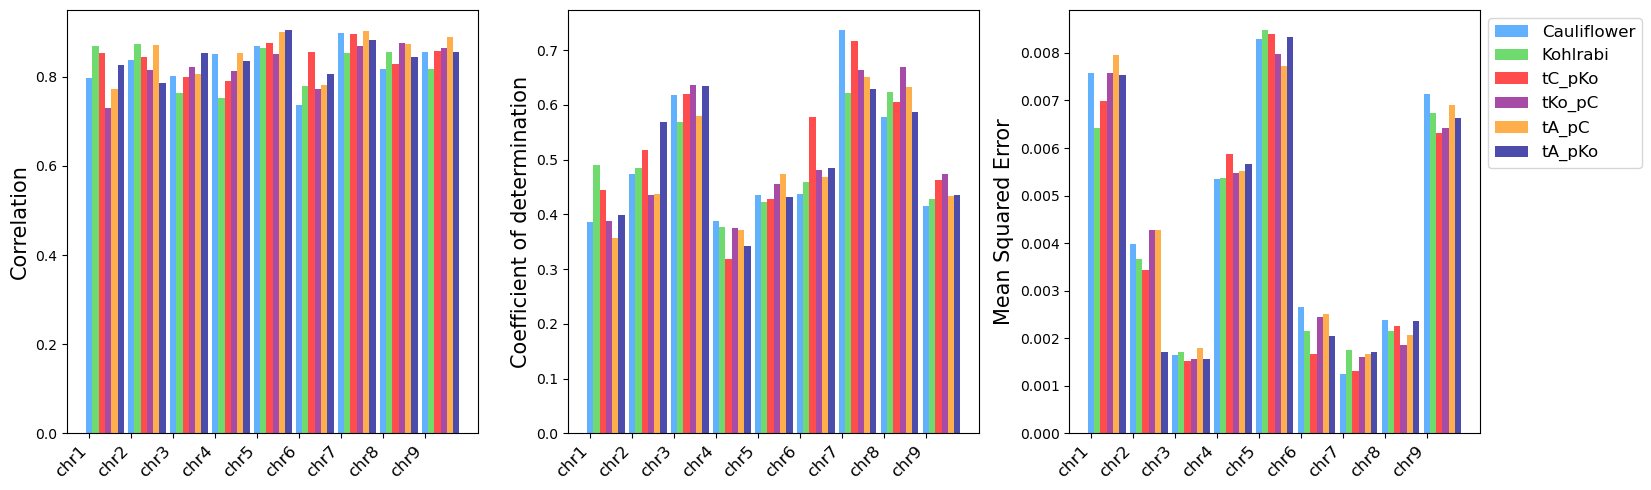

In [57]:
# Adjusting bar width
bar_width = 0.15

# Creating data positions
bar_positions_c = np.arange(len(c_table['chr']))
bar_positions_ko = bar_positions_c + bar_width
bar_positions_tc_pko = bar_positions_ko + bar_width
bar_positions_tko_pc = bar_positions_tc_pko + bar_width
bar_positions_ta_pc = bar_positions_tko_pc + bar_width
bar_positions_ta_pko = bar_positions_ta_pc + bar_width

# Creating subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First chart
axs[0].bar(bar_positions_c, c_table['corr'], color='dodgerblue', width=bar_width, label='Cauliflower', alpha=0.7)
axs[0].bar(bar_positions_ko, ko_table['corr'], color='limegreen', width=bar_width, label='Kohlrabi', alpha=0.7)
axs[0].bar(bar_positions_tc_pko, tc_pko_table['corr'], color='red', width=bar_width, label='tC_pKo', alpha=0.7)
axs[0].bar(bar_positions_tko_pc, tko_pc_table['corr'], color='purple', width=bar_width, label='tKo_pC', alpha=0.7)
axs[0].bar(bar_positions_ta_pc, ta_pc_table['corr'], color='darkorange', width=bar_width, label='tA_pC', alpha=0.7)
axs[0].bar(bar_positions_ta_pko, ta_pko_table['corr'], color='darkblue', width=bar_width, label='tA_pKo', alpha=0.7)

axs[0].set_ylabel('Correlation', fontsize=15)

# Second chart
axs[1].bar(bar_positions_c, c_table['R^2'], color='dodgerblue', width=bar_width, label='Cauliflower', alpha=0.7)
axs[1].bar(bar_positions_ko, ko_table['R^2'], color='limegreen', width=bar_width, label='Kohlrabi', alpha=0.7)
axs[1].bar(bar_positions_tc_pko, tc_pko_table['R^2'], color='red', width=bar_width, label='tC_pKo', alpha=0.7)
axs[1].bar(bar_positions_tko_pc, tko_pc_table['R^2'], color='purple', width=bar_width, label='tKo_pC', alpha=0.7)
axs[1].bar(bar_positions_ta_pc, ta_pc_table['R^2'], color='darkorange', width=bar_width, label='tA_pC', alpha=0.7)
axs[1].bar(bar_positions_ta_pko, ta_pko_table['R^2'], color='darkblue', width=bar_width, label='tA_pKo', alpha=0.7)

axs[1].set_ylabel('Coefficient of determination', fontsize=15)

# Third chart

axs[2].bar(bar_positions_c, c_table['MSE'], color='dodgerblue', width=bar_width, label='Cauliflower', alpha=0.7)
axs[2].bar(bar_positions_ko, ko_table['MSE'], color='limegreen', width=bar_width, label='Kohlrabi', alpha=0.7)
axs[2].bar(bar_positions_tc_pko, tc_pko_table['MSE'], color='red', width=bar_width, label='tC_pKo', alpha=0.7)
axs[2].bar(bar_positions_tko_pc, tko_pc_table['MSE'], color='purple', width=bar_width, label='tKo_pC', alpha=0.7)
axs[2].bar(bar_positions_ta_pc, ta_pc_table['MSE'], color='darkorange', width=bar_width, label='tA_pC', alpha=0.7)
axs[2].bar(bar_positions_ta_pko, ta_pko_table['MSE'], color='darkblue', width=bar_width, label='tA_pKo', alpha=0.7)

axs[2].set_ylabel('Mean Squared Error', fontsize=15)

# Get chromosome labels from the 'chr' column
chr_labels = c_table['chr']

# Set x-axis labels for all three subplots
for ax in axs:
    ax.set_xticks(bar_positions_c)
    ax.set_xticklabels(chr_labels)

# Rotate labels for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Adjusting layout
plt.tight_layout()

# Place legend outside the subplots and above the last subplot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Show the figure
plt.show()

In [58]:
summary = {'Training_set': ['Cauliflower', 'Kohlrabi', 'Cauliflower', 'Kohlrabi', 'All_except_Cauliflower', 'All_except_Kohlrabi'],
           'Testing_set': ['Cauliflower', 'Kohlrabi', 'Kohlrabi', 'Cauliflower', 'Cauliflower', 'Kohlrabi', ],
           'corr': [c_table.describe().iloc[1,0].round(3), ko_table.describe().iloc[1,0].round(3), tc_pko_table.describe().iloc[1,0].round(3), tko_pc_table.describe().iloc[1,0].round(3), ta_pc_table.describe().iloc[1,0].round(3), ta_pko_table.describe().iloc[1,0].round(3)],
           'R^2': [c_table.describe().iloc[1,1].round(3), ko_table.describe().iloc[1,1].round(3), tc_pko_table.describe().iloc[1,1].round(3), tko_pc_table.describe().iloc[1,1].round(3), ta_pc_table.describe().iloc[1,1].round(3), ta_pko_table.describe().iloc[1,1].round(3)],
           'MSE': [c_table.describe().iloc[1,2].round(3), ko_table.describe().iloc[1,2].round(3), tc_pko_table.describe().iloc[1,2].round(3), tko_pc_table.describe().iloc[1,2].round(3), ta_pc_table.describe().iloc[1,2].round(3), ta_pko_table.describe().iloc[1,2].round(3)]}

summary = pd.DataFrame(summary)
summary

Training_set  Testing_set   corr    R^2    MSE
0             Cauliflower  Cauliflower  0.829  0.497  0.004
1                Kohlrabi     Kohlrabi  0.825  0.497  0.004
2             Cauliflower     Kohlrabi  0.844  0.521  0.004
3                Kohlrabi  Cauliflower  0.823  0.509  0.004
4  All_except_Cauliflower  Cauliflower  0.850  0.489  0.004
5     All_except_Kohlrabi     Kohlrabi  0.844  0.502  0.004

In [60]:
summary.to_csv('./output/performance_models_cauliflower_kohlrabi_expression.csv', index = None)